In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_test
import seis_invert
import seis_prior
#import seis_nn
import cupy as cp
import seis_diagnostics
import seis_forward
import seis_forward2
import seis_model

F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


In [2]:
#data2=kgs.load_all_test_data()+
data2=kgs.load_all_train_data()

In [3]:
df = kgs.dill_load(kgs.temp_dir + '/style_B_df.pickle')
tr = df['is_train']
ntr = np.logical_not(df['is_train'])
df2 = df[tr].sort_values('seis_err_rms', ascending=False)
print(df2)
data = []
for cn in df2['cache_name'][:50]:
    for d in data2:
        if d.cache_name() == cn:
            #print(cn)
            data.append(d)

              cache_name  is_train  update_mae  score_brendan      score  \
188  data1__Style_B__376      True   55.078311      62.328757  37.194834   
157  data1__Style_B__314      True   60.459100      71.931102  44.918423   
216  data1__Style_B__432      True   43.456679      58.968321  40.964142   
187  data1__Style_B__374      True   38.301720      48.964153  33.972459   
8     data1__Style_B__16      True   40.336740      56.171914  40.324762   
..                   ...       ...         ...            ...        ...   
120  data1__Style_B__240      True   26.599199      33.852749  24.200757   
193  data1__Style_B__386      True   36.705993      42.089632  25.856482   
245  data1__Style_B__490      True   28.677122      35.096020  24.747772   
135  data1__Style_B__270      True   31.830748      35.045888  20.286637   
72   data1__Style_B__144      True   24.021914      28.843061  20.272838   

               seis_err_rms  seis_err_rms_brendan  
188    7.83981361069365e-05   0.061

capturing graph


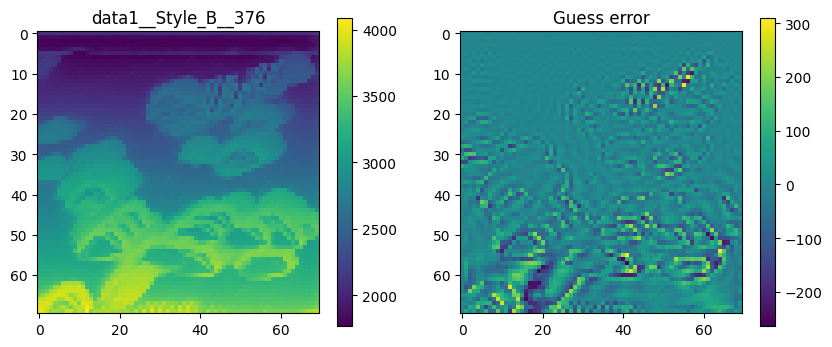

diag 2.180650093766887e-05
capturing graph
capturing graph


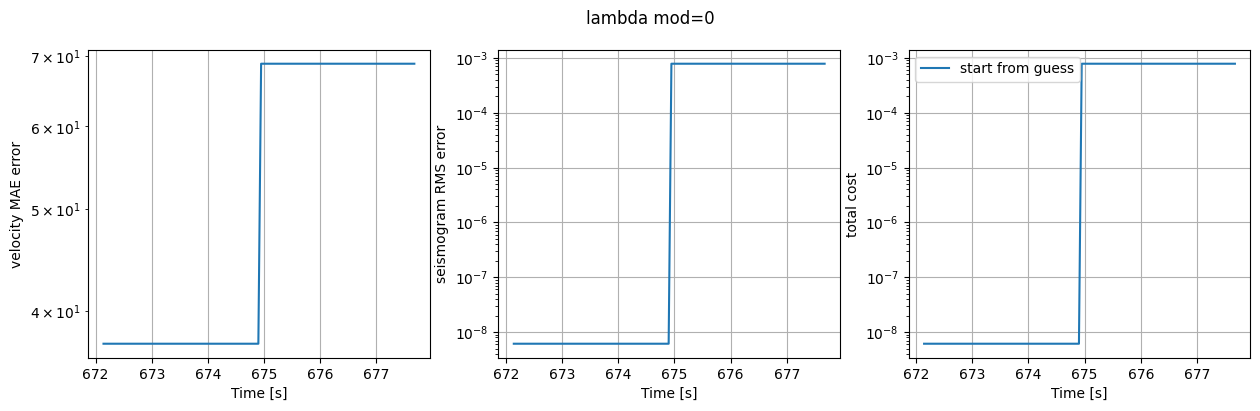

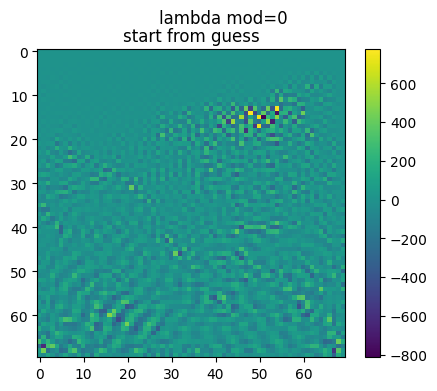

diag 2.180650093766887e-05


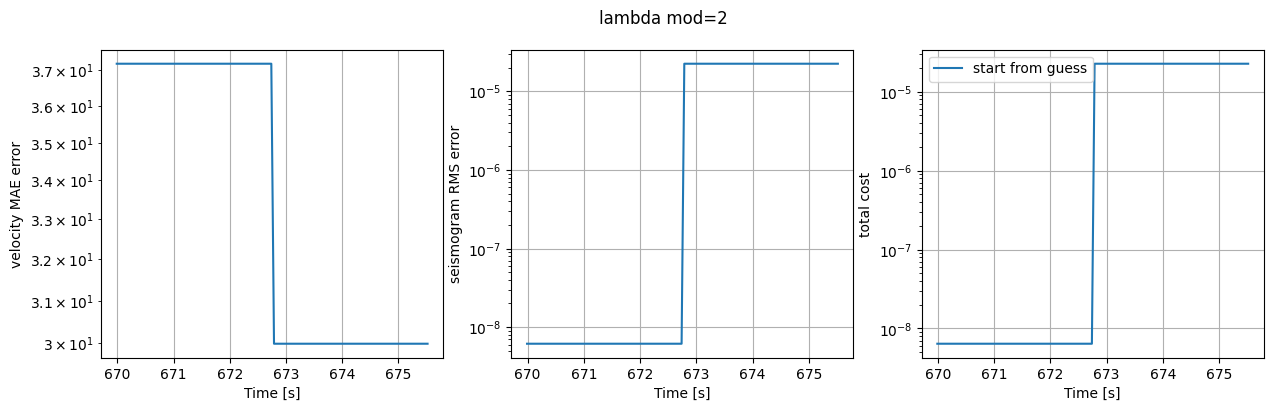

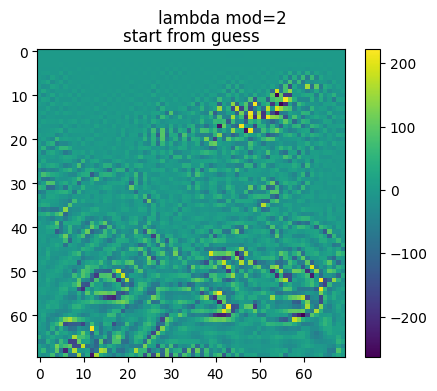

diag 2.180650093766887e-05


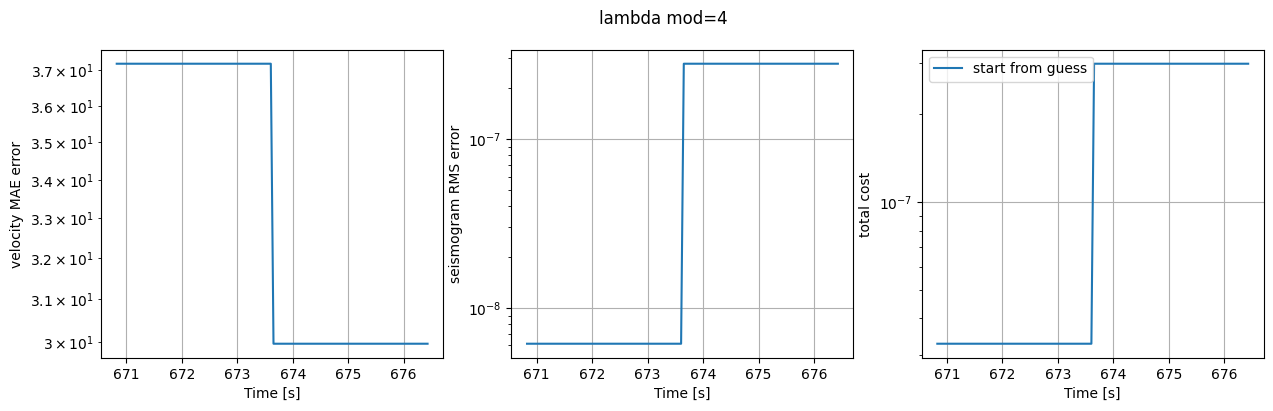

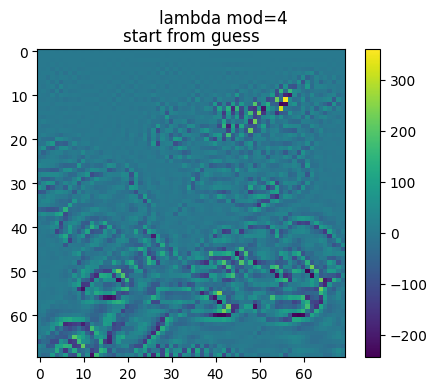

diag 2.180650093766887e-05


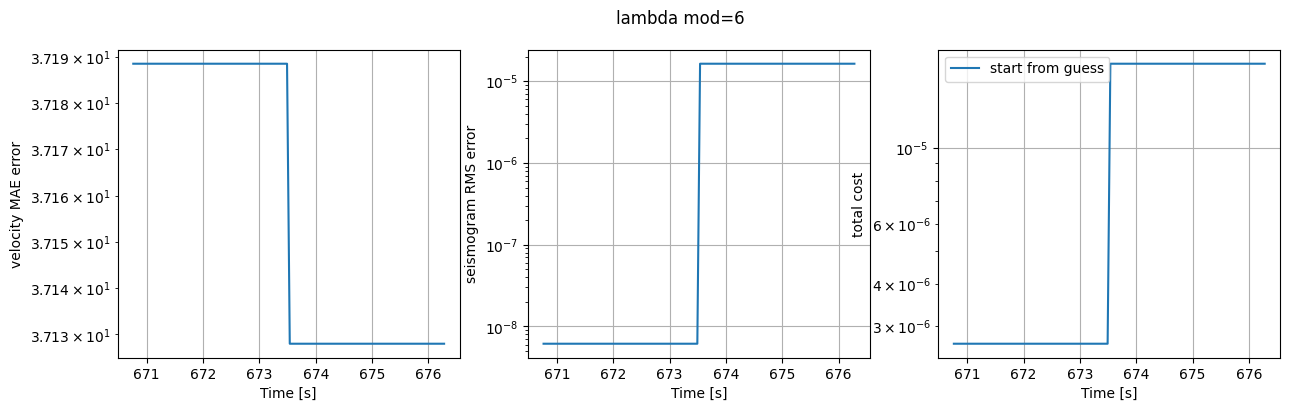

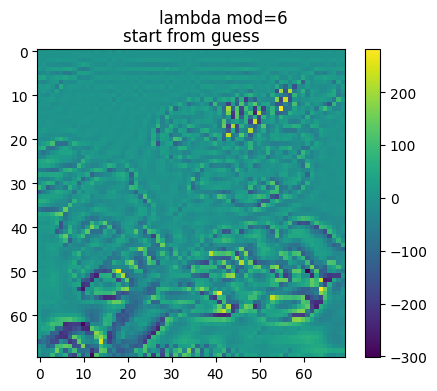

diag 2.180650093766887e-05


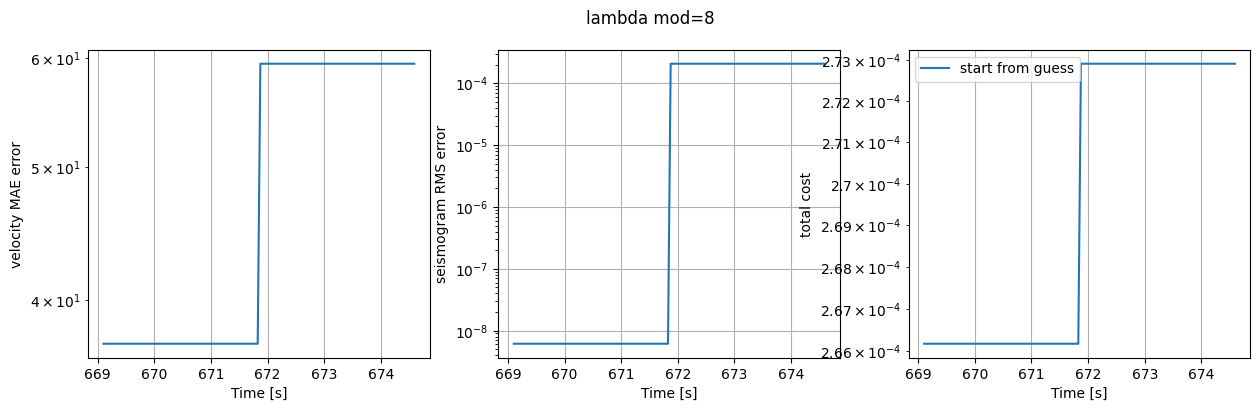

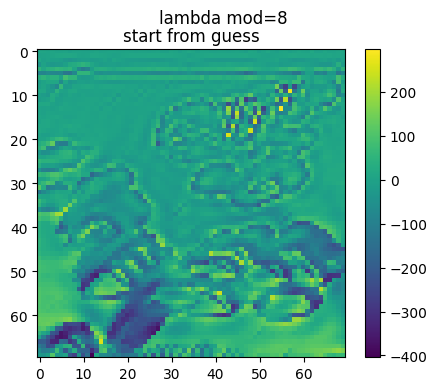

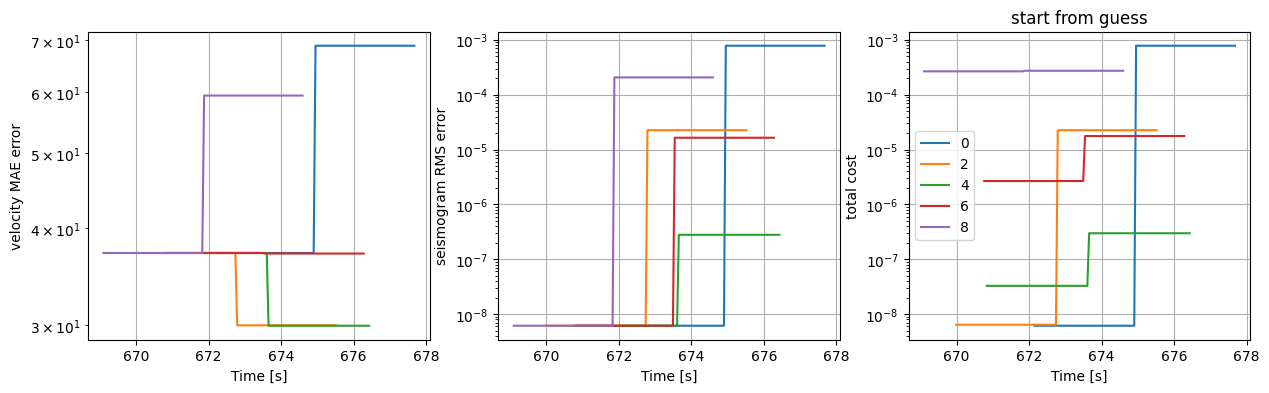

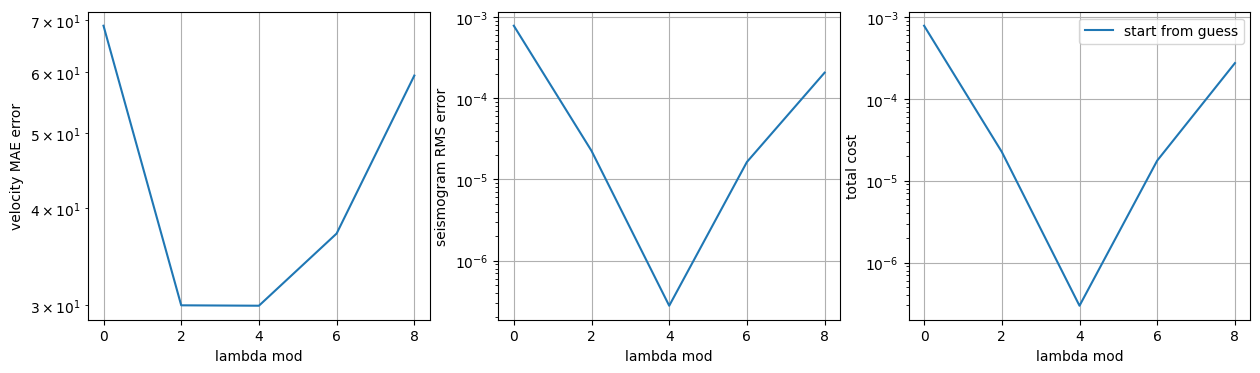

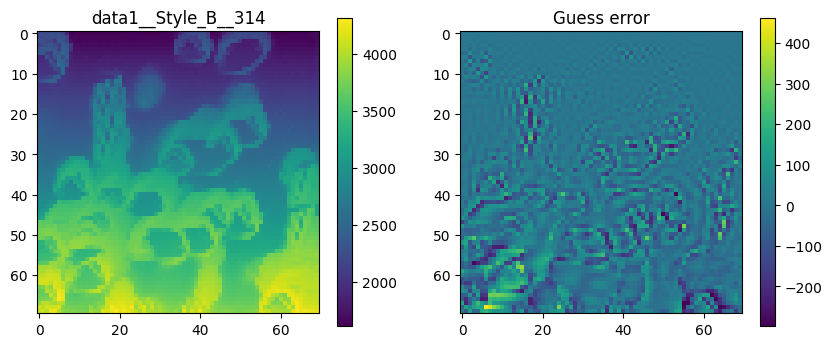

diag 2.4211736594644592e-05


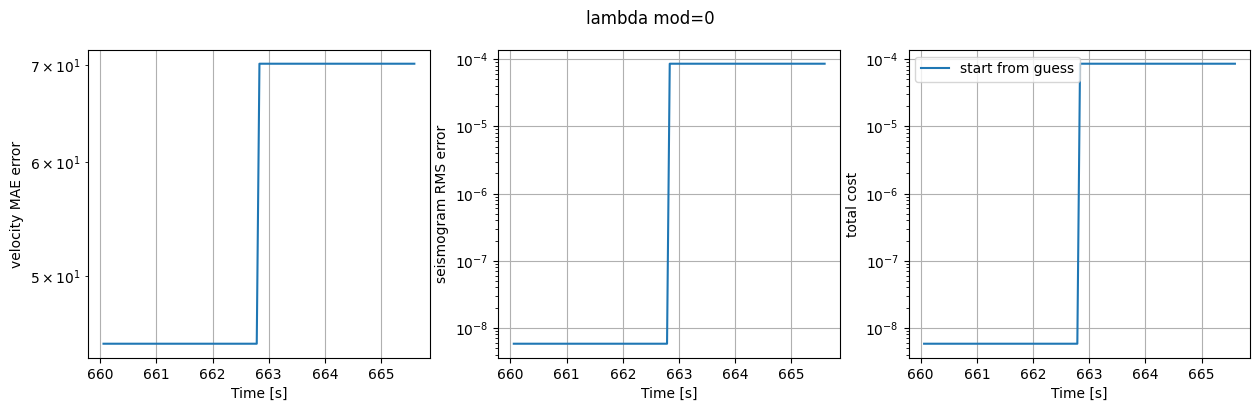

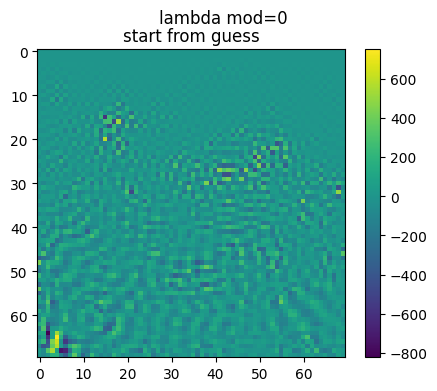

diag 2.4211736594644592e-05


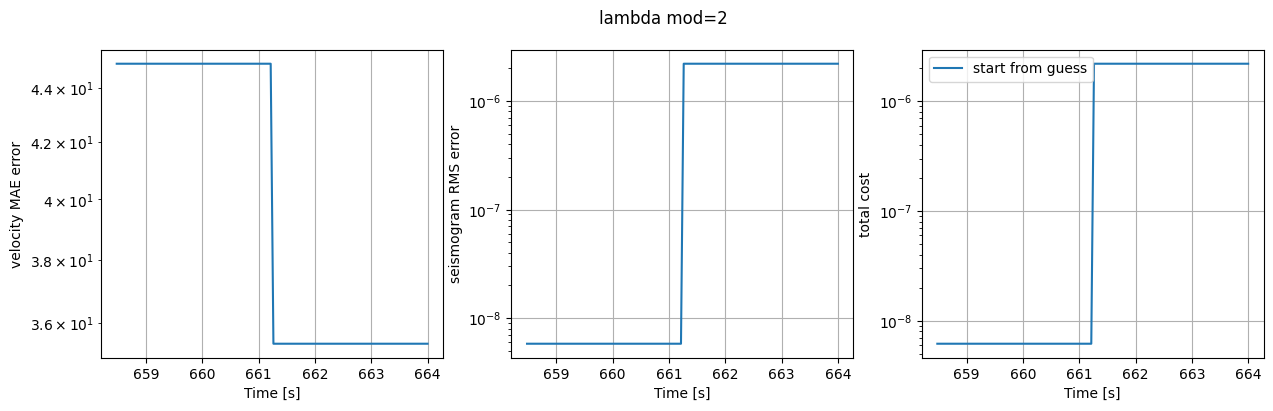

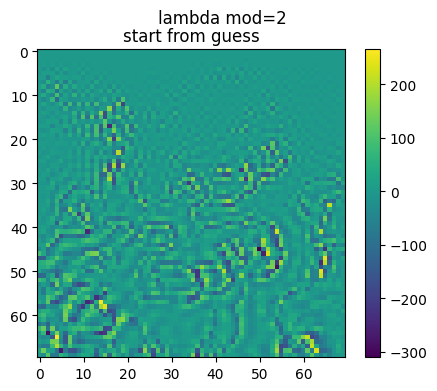

diag 2.4211736594644592e-05


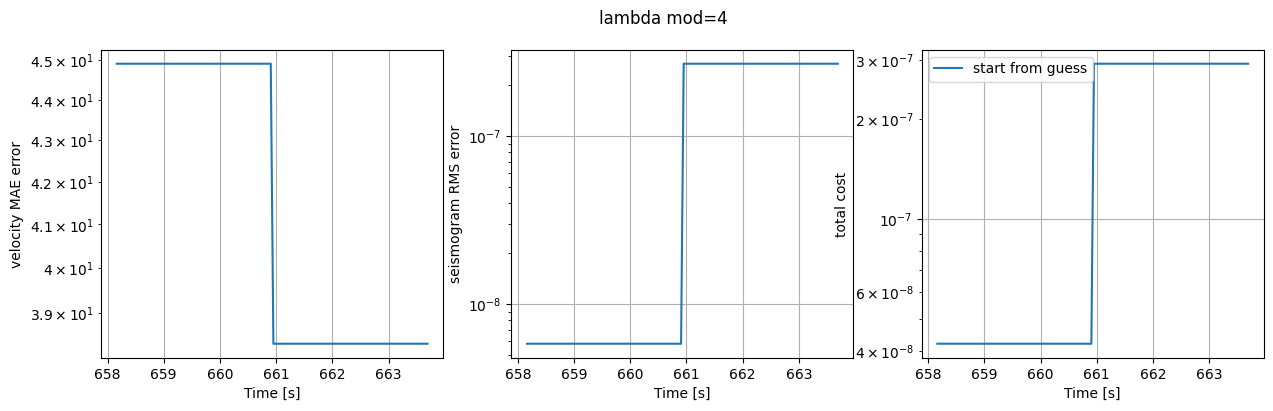

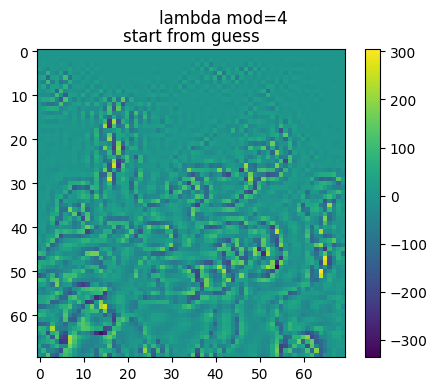

diag 2.4211736594644592e-05


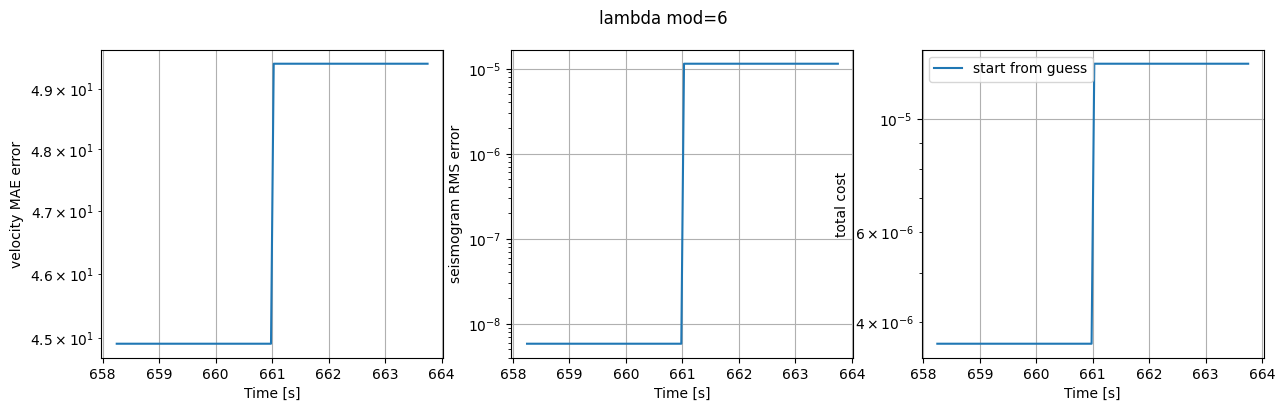

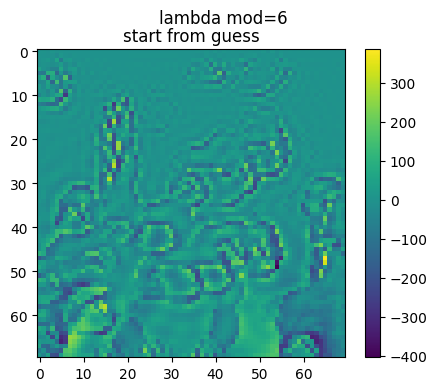

diag 2.4211736594644592e-05


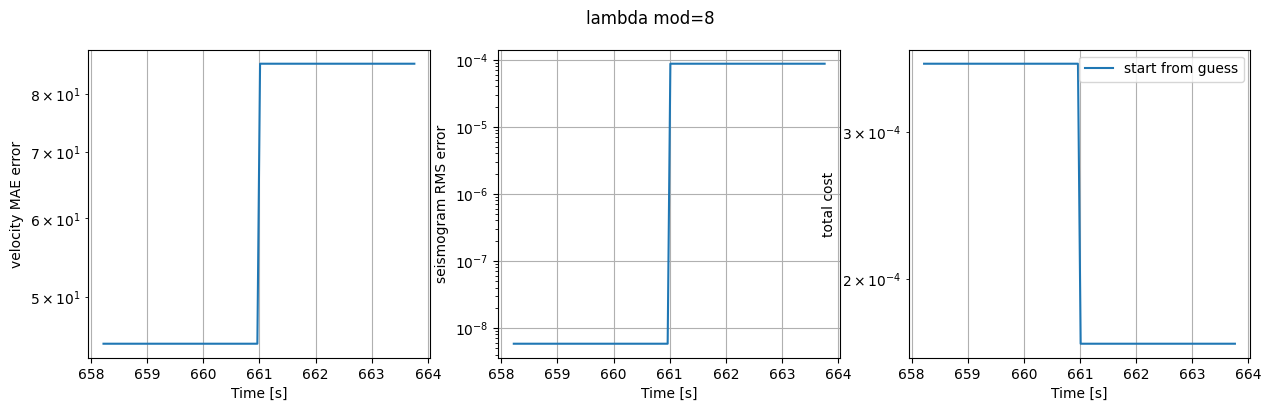

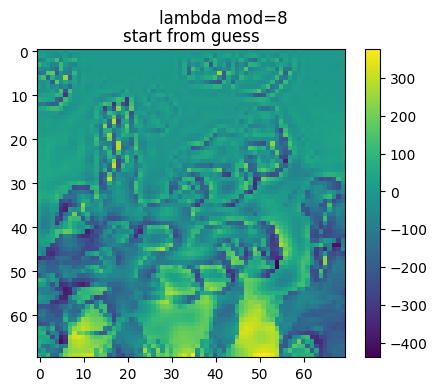

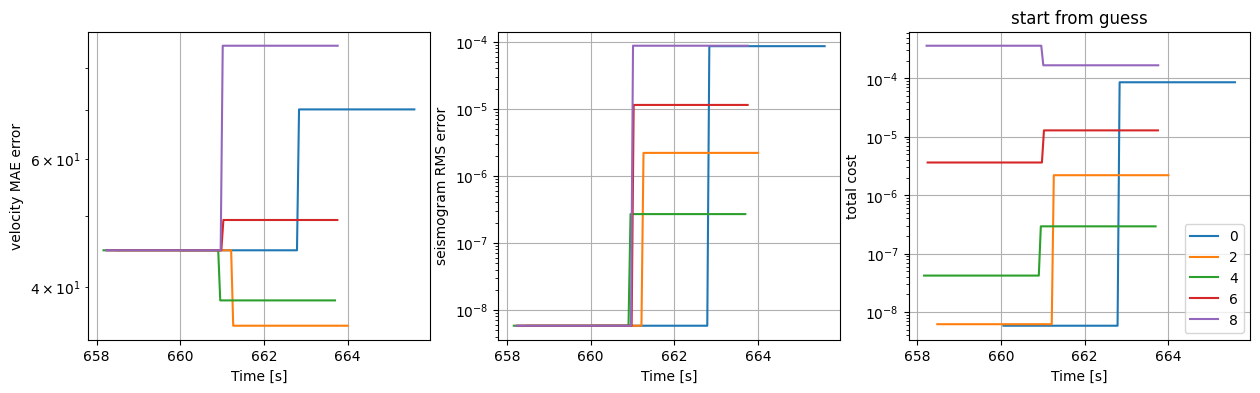

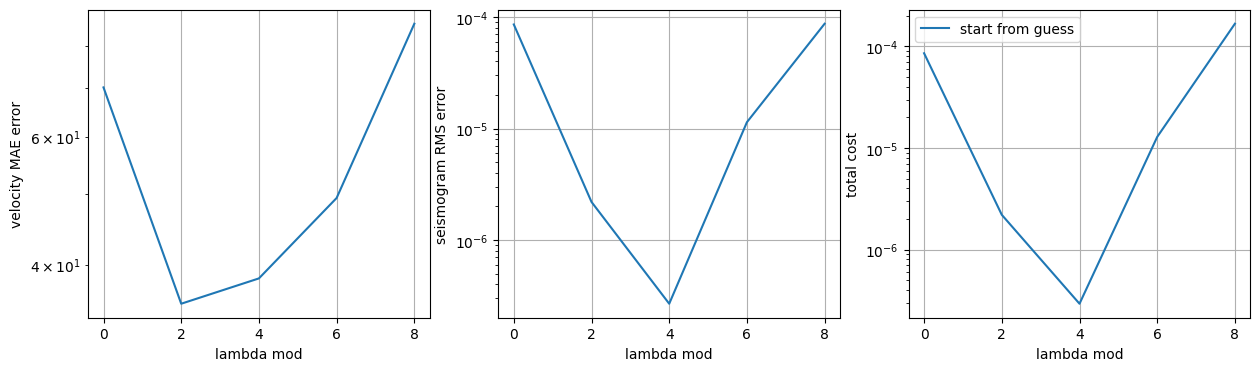

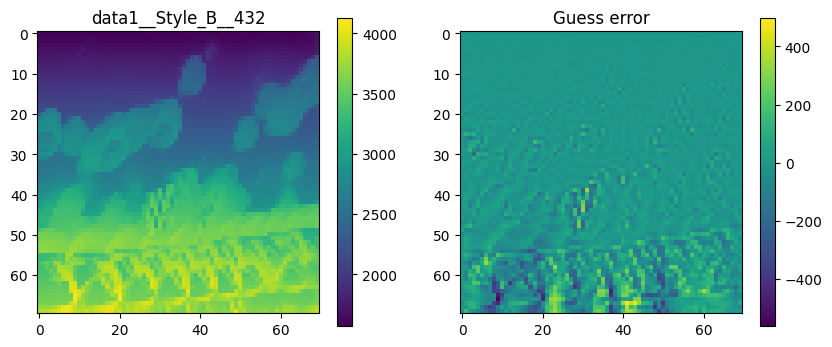

diag 1.7384191088759438e-05


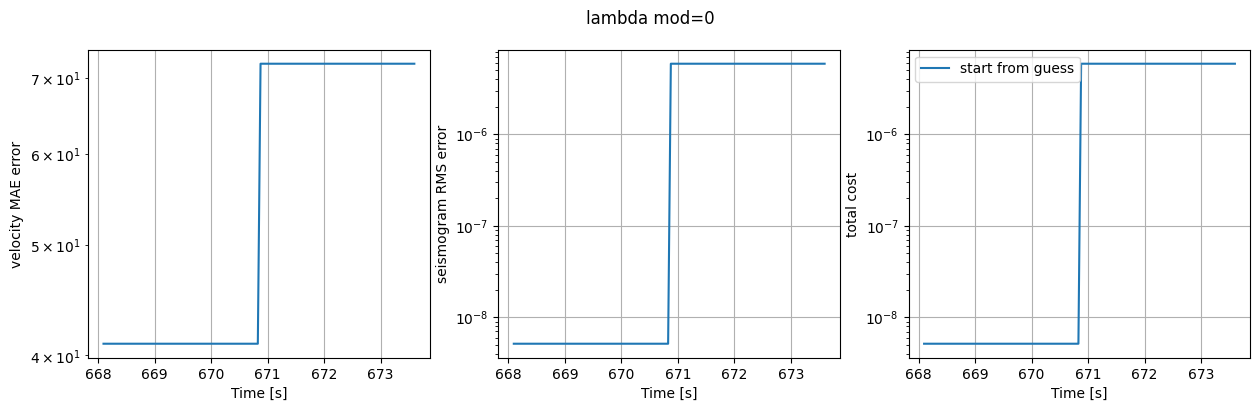

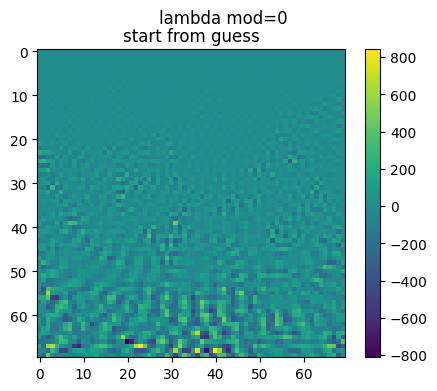

diag 1.7384191088759438e-05


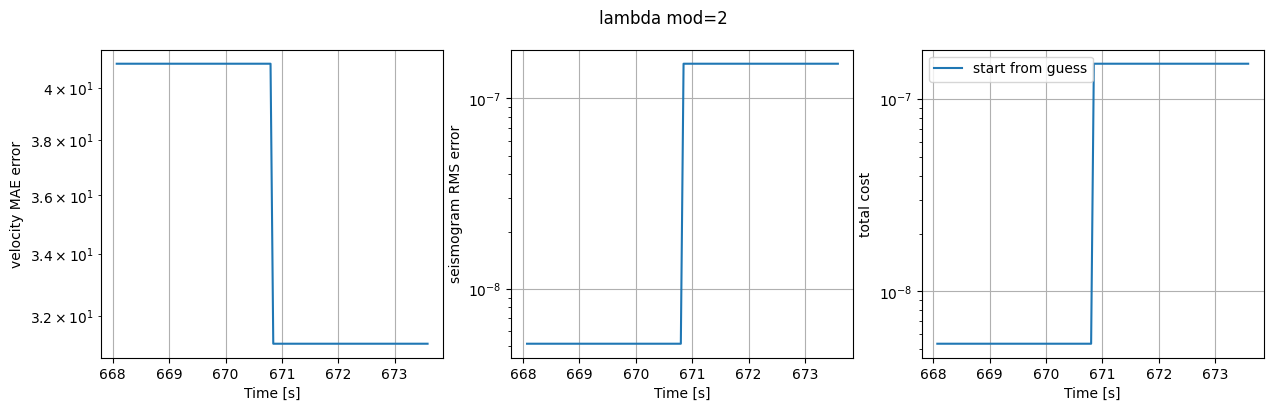

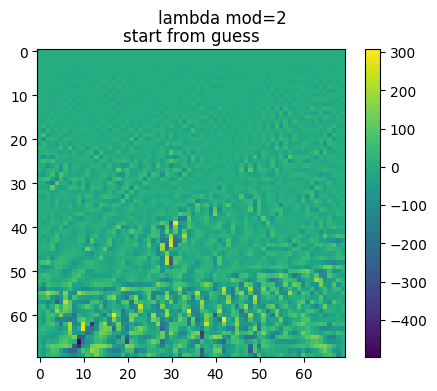

diag 1.7384191088759438e-05


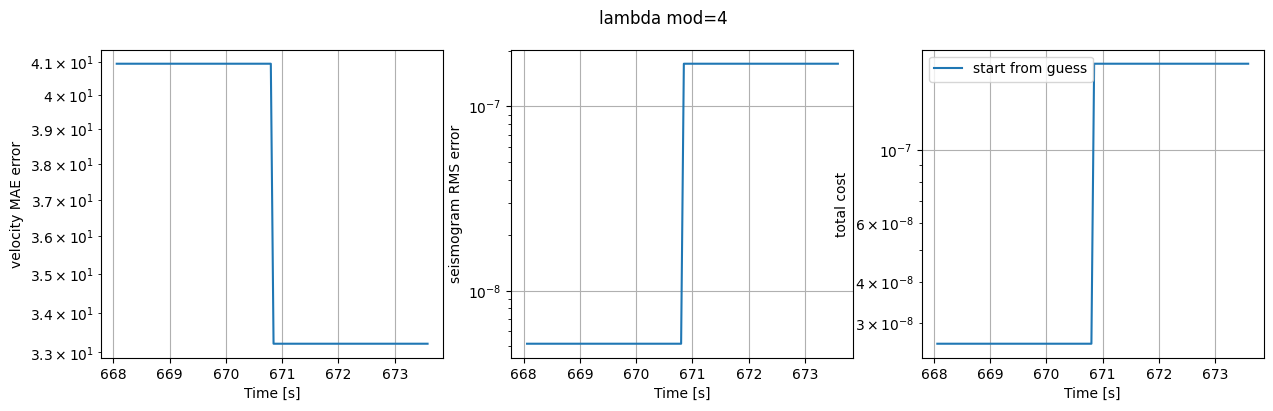

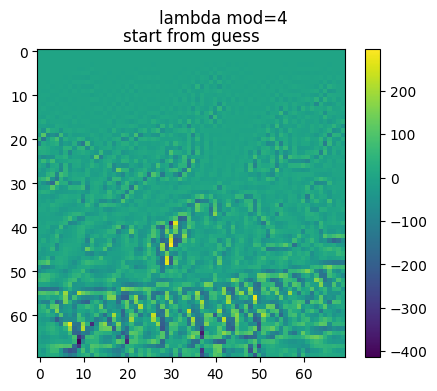

diag 1.7384191088759438e-05


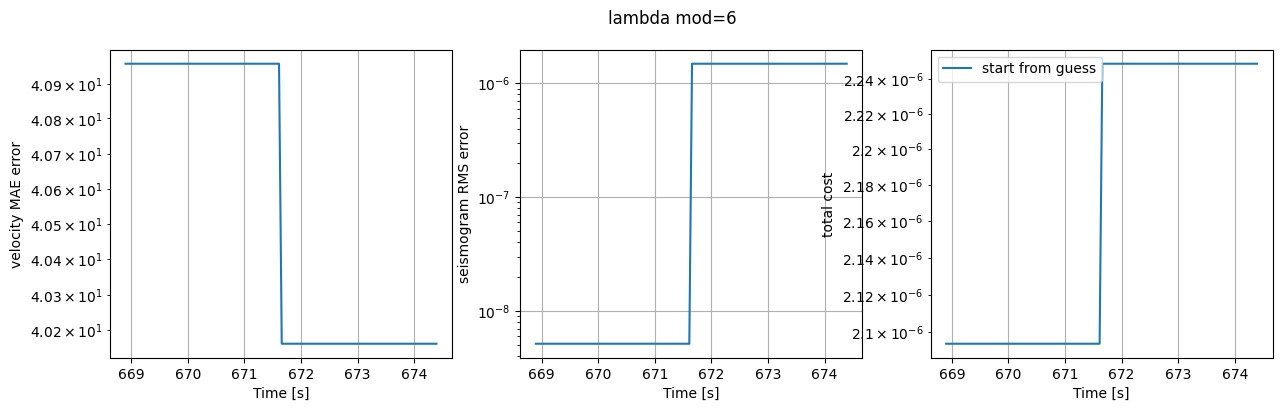

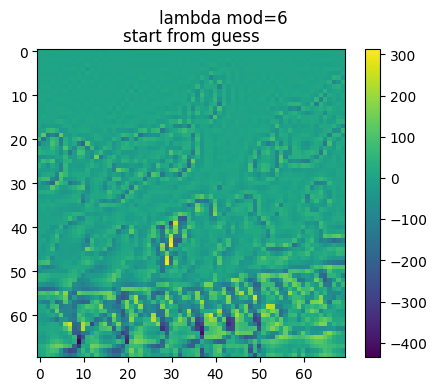

diag 1.7384191088759438e-05


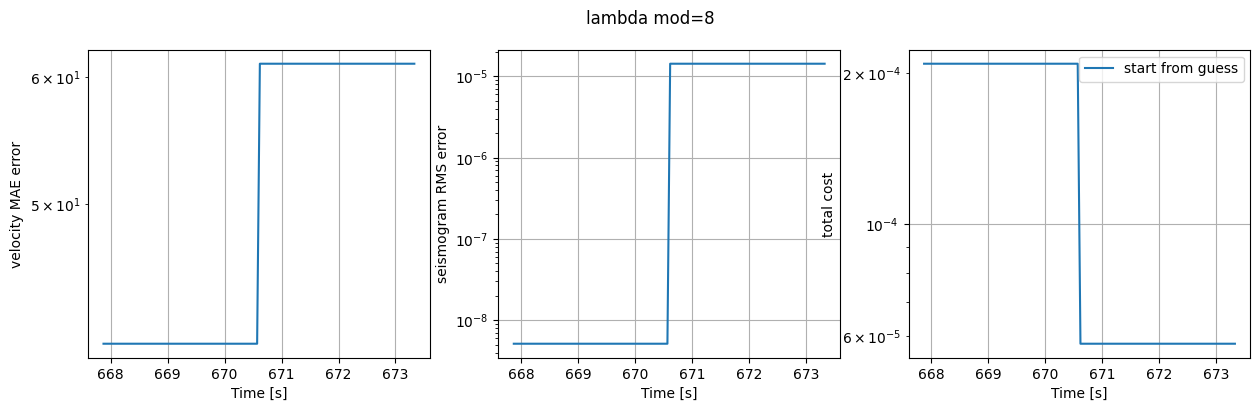

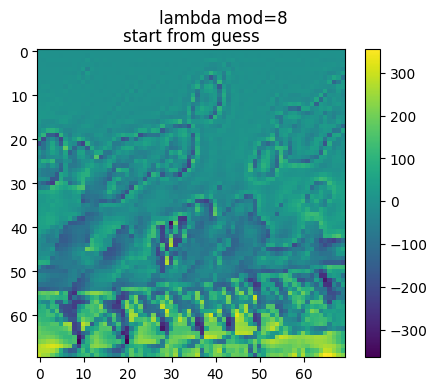

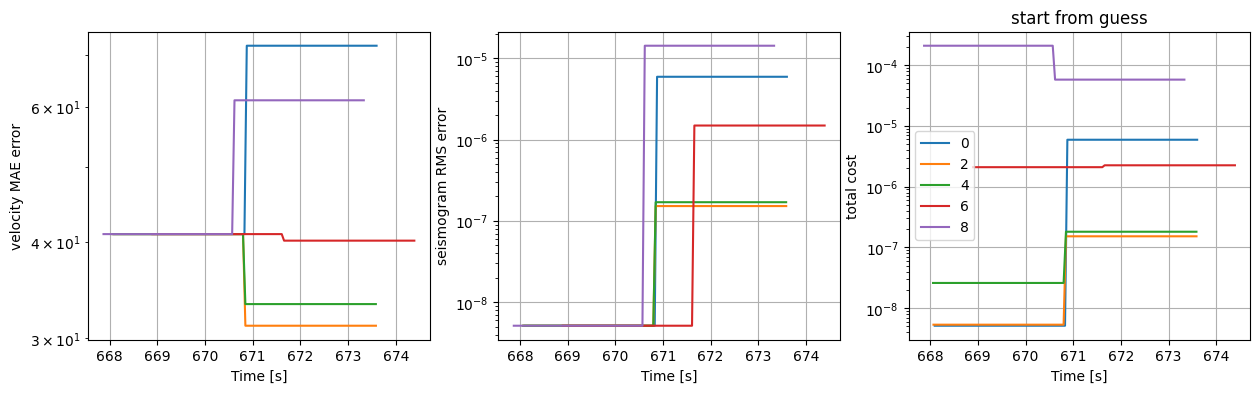

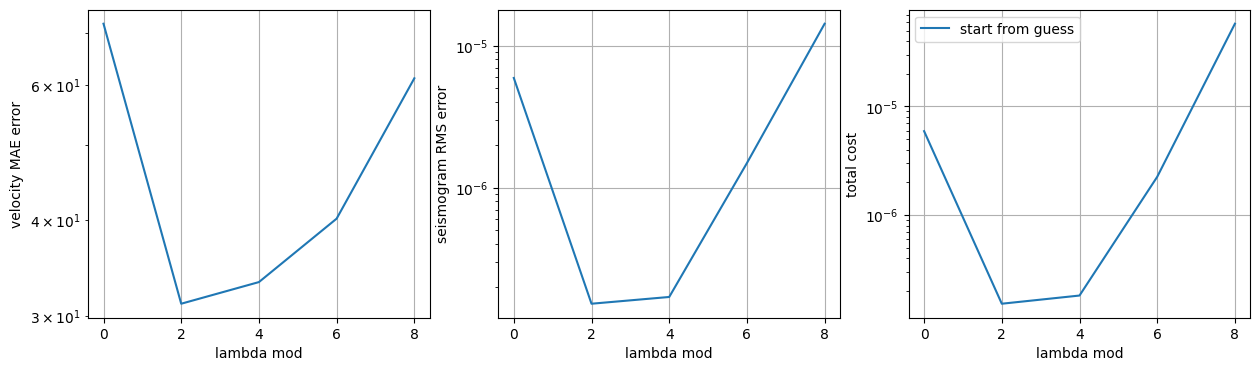

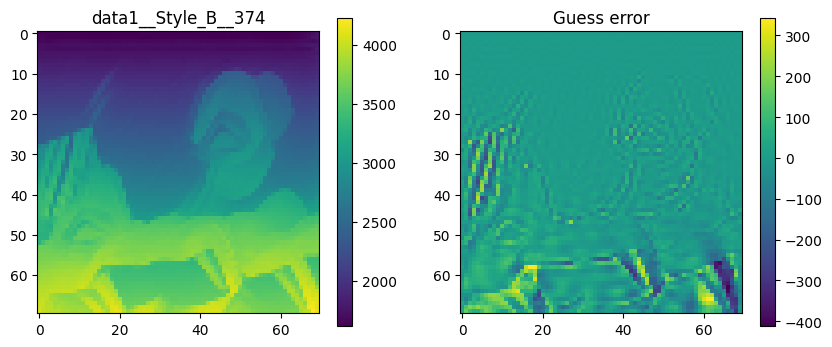

diag 1.7170273620393758e-05


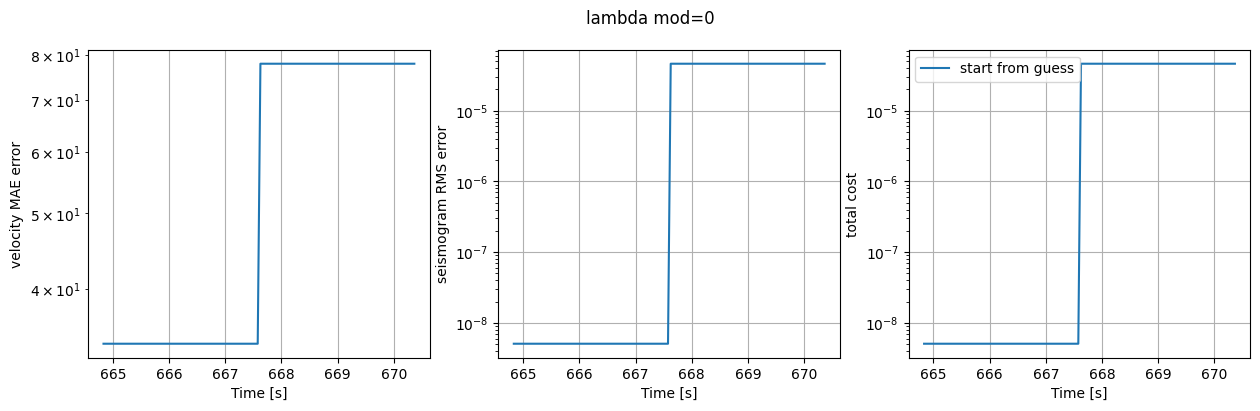

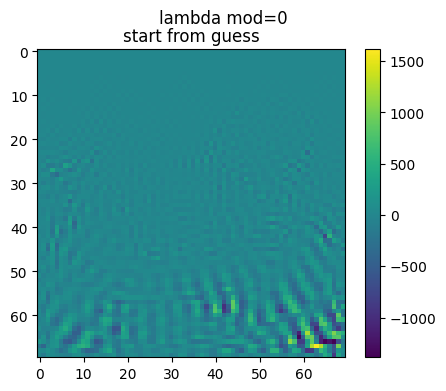

diag 1.7170273620393758e-05


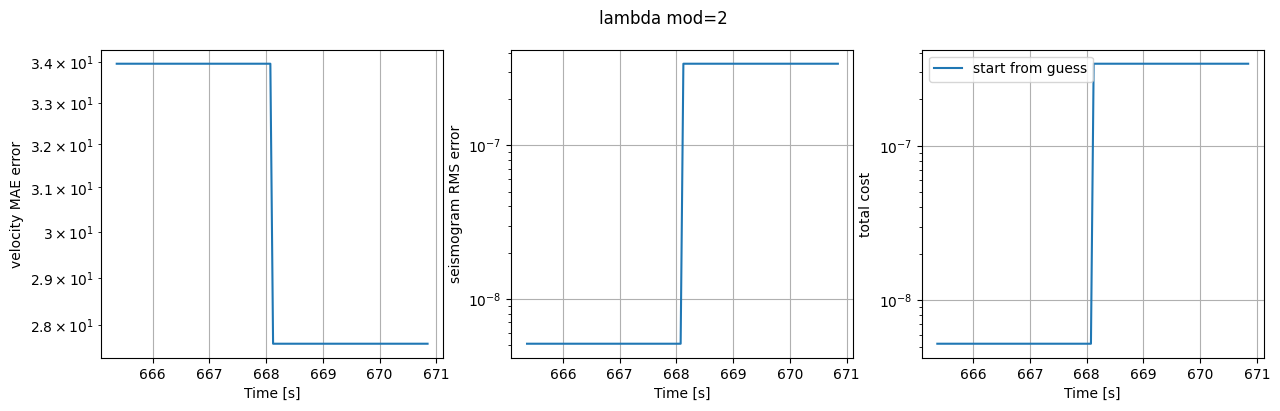

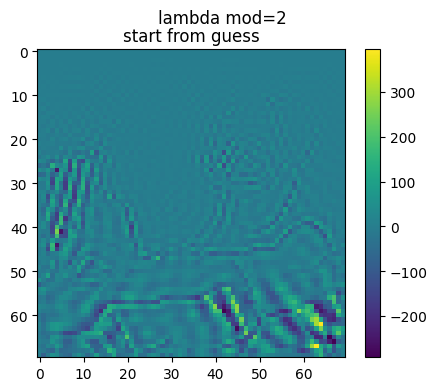

diag 1.7170273620393758e-05


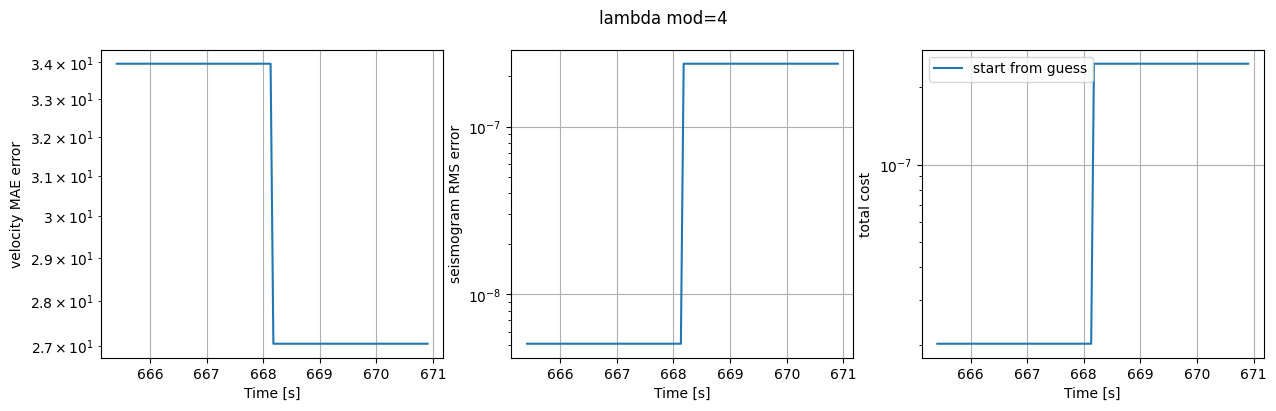

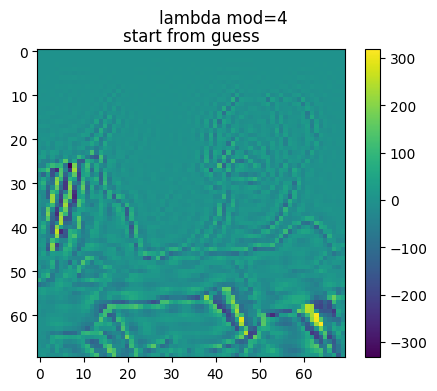

diag 1.7170273620393758e-05


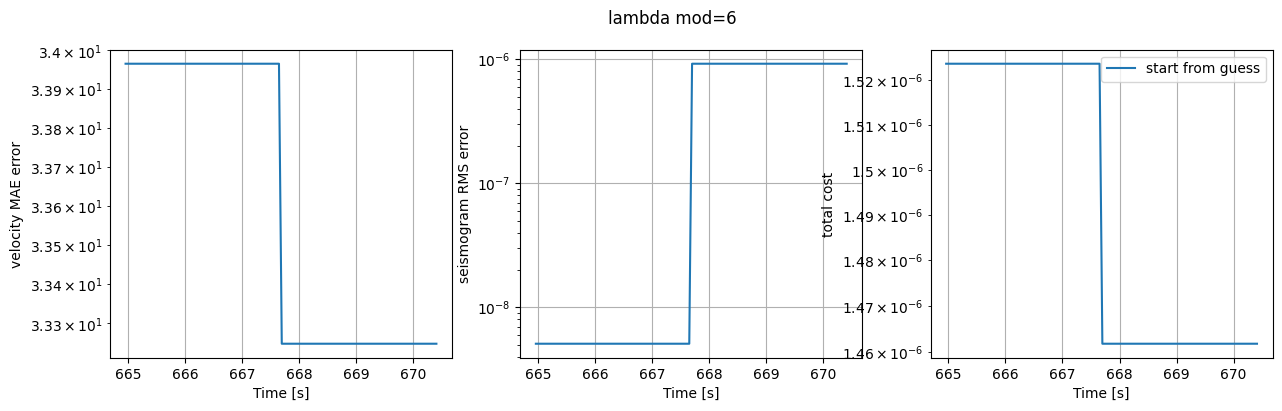

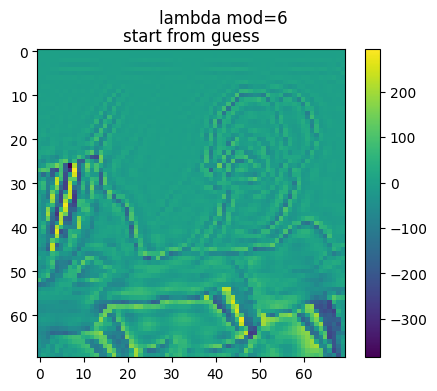

diag 1.7170273620393758e-05


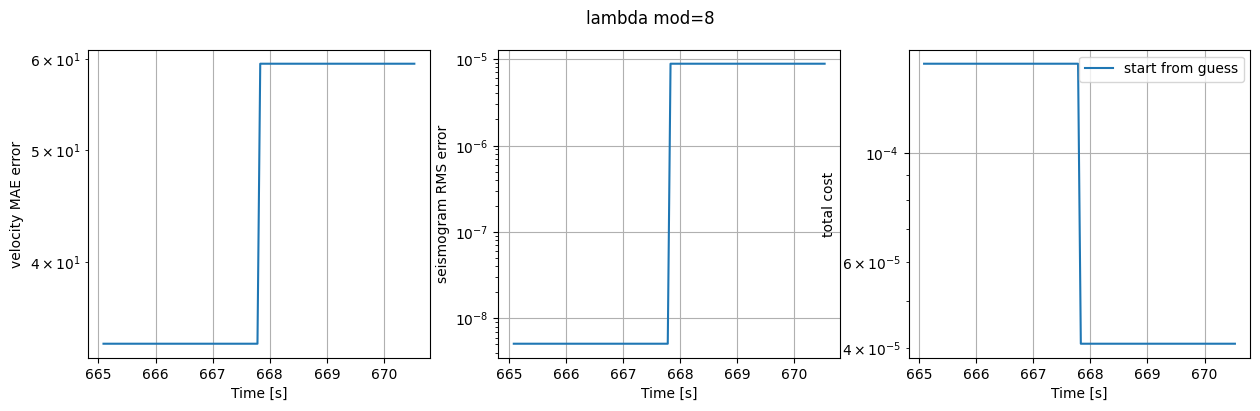

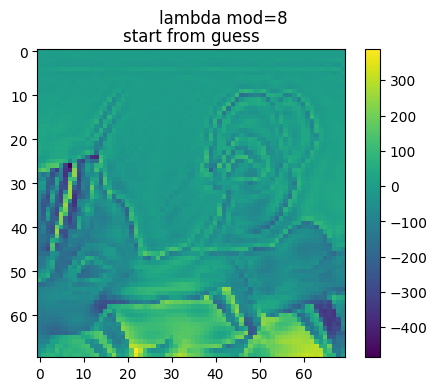

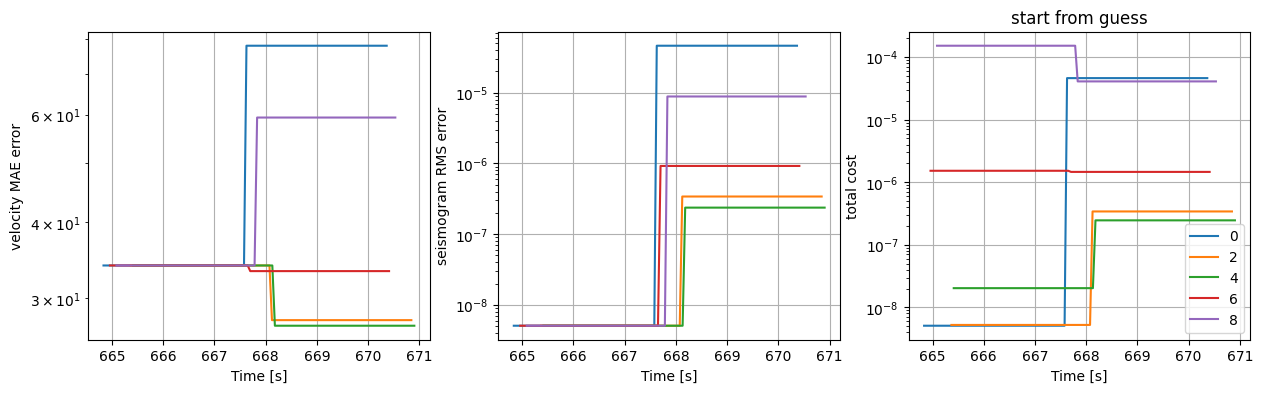

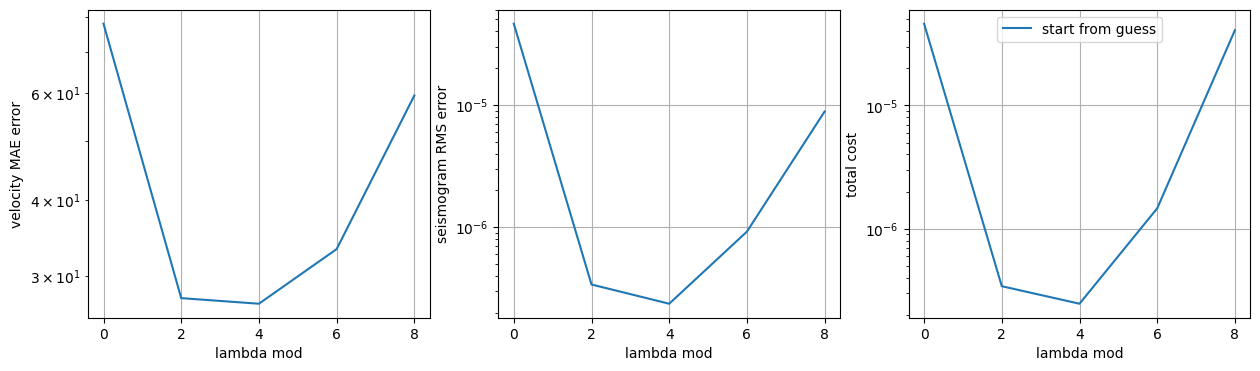

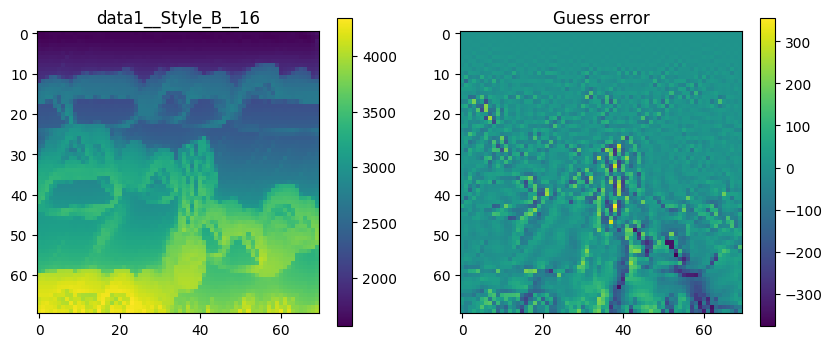

diag 2.173353542053898e-05


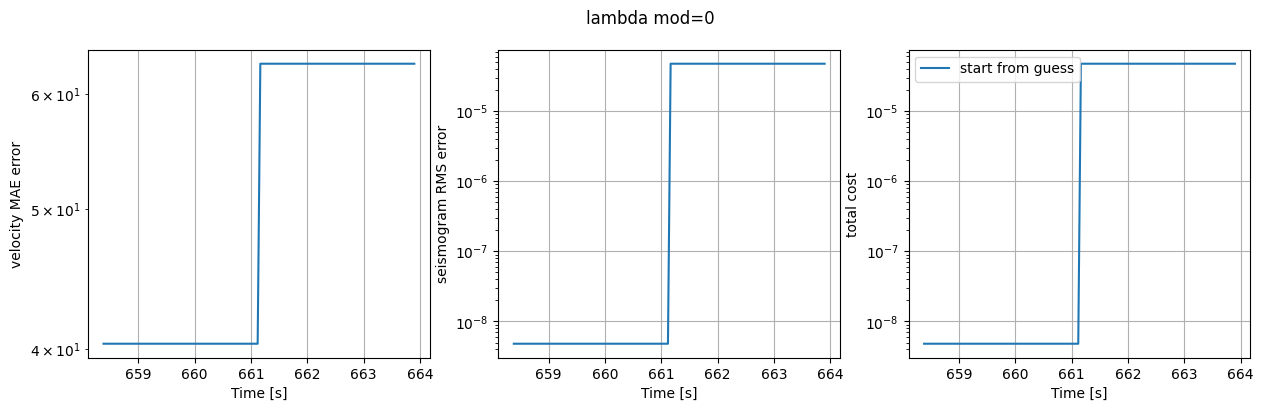

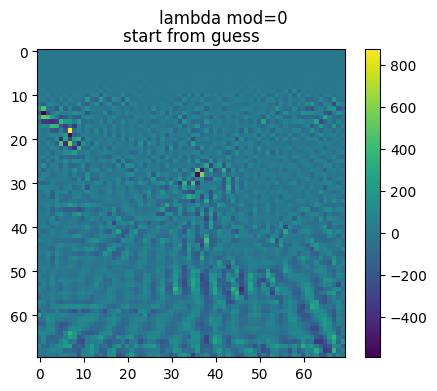

diag 2.173353542053898e-05


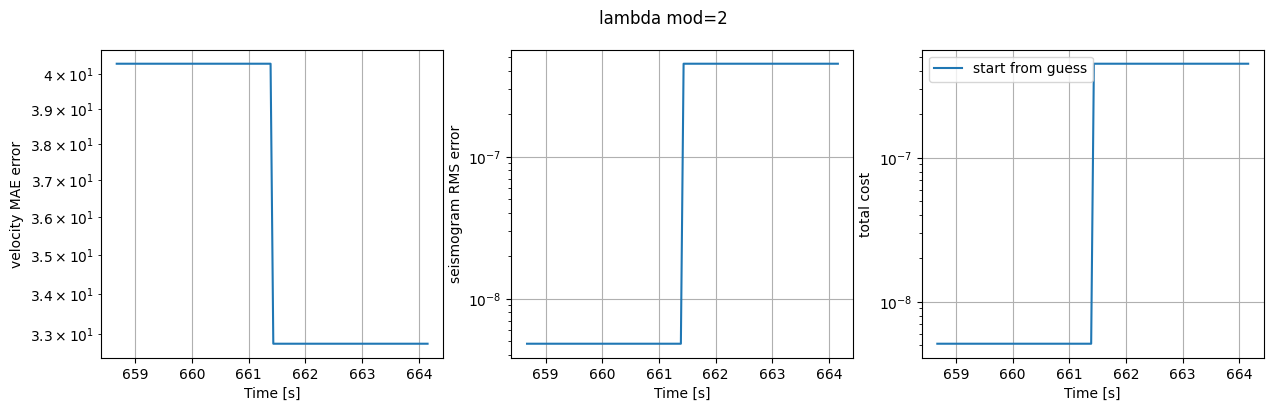

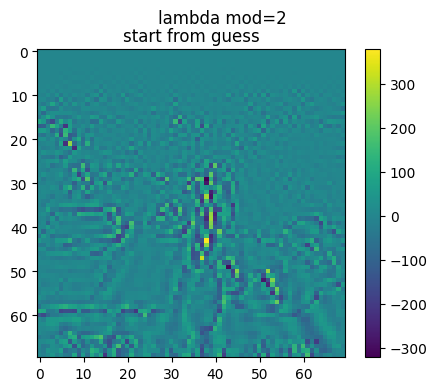

diag 2.173353542053898e-05


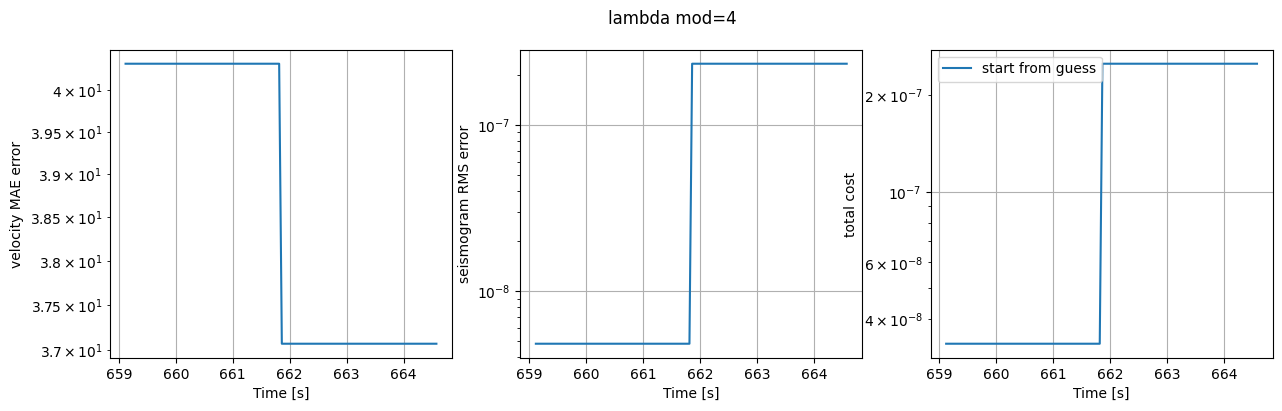

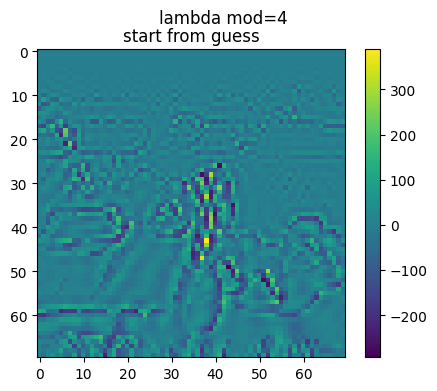

diag 2.173353542053898e-05


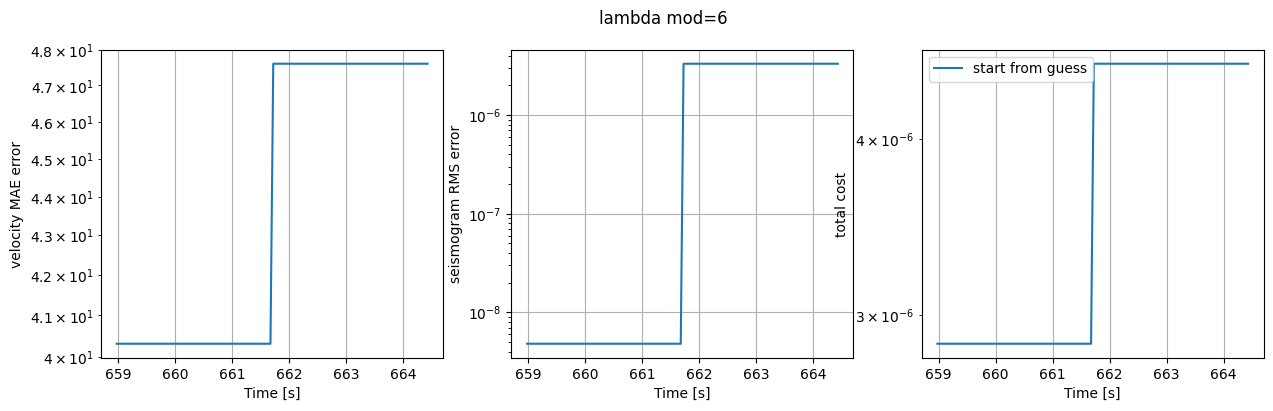

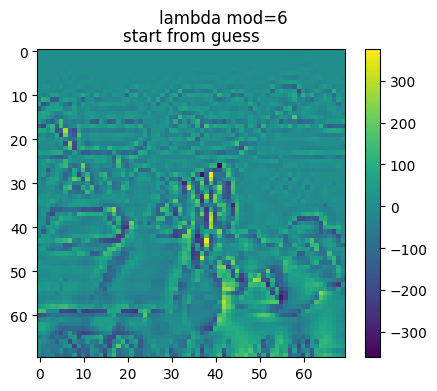

diag 2.173353542053898e-05


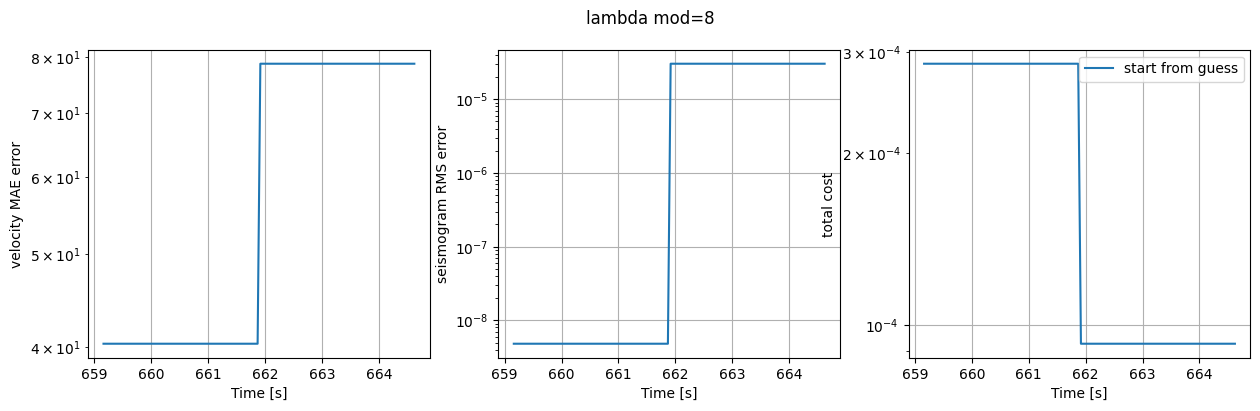

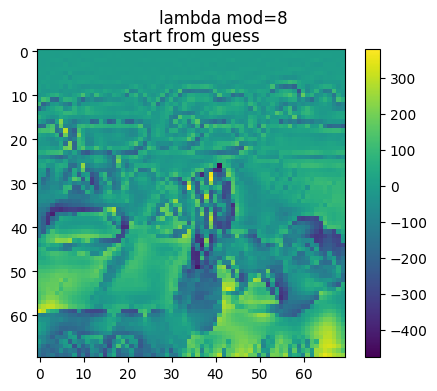

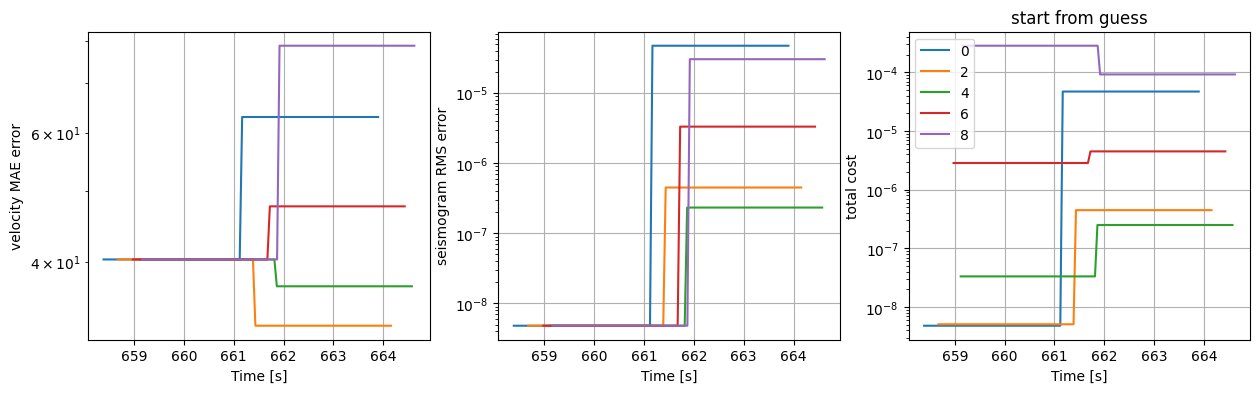

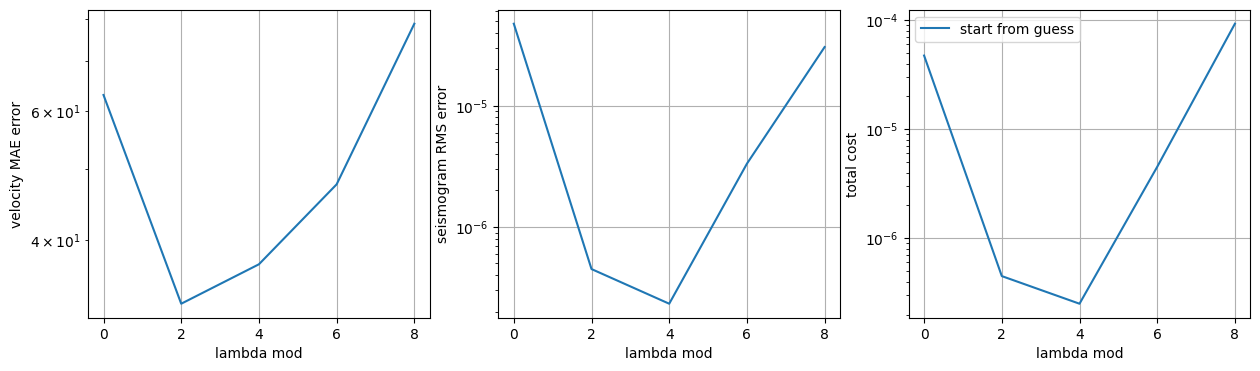

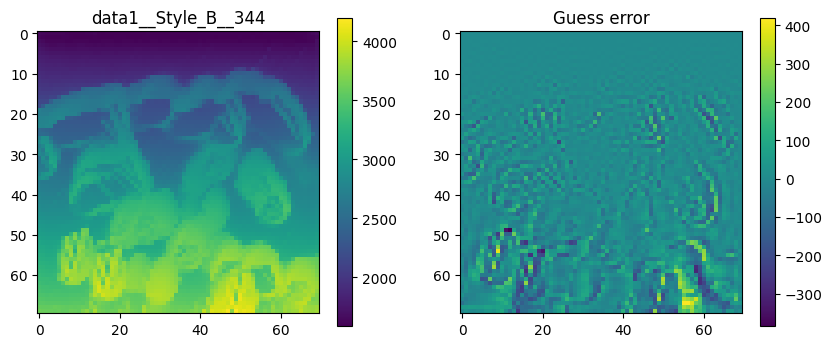

diag 1.6256417939039762e-05


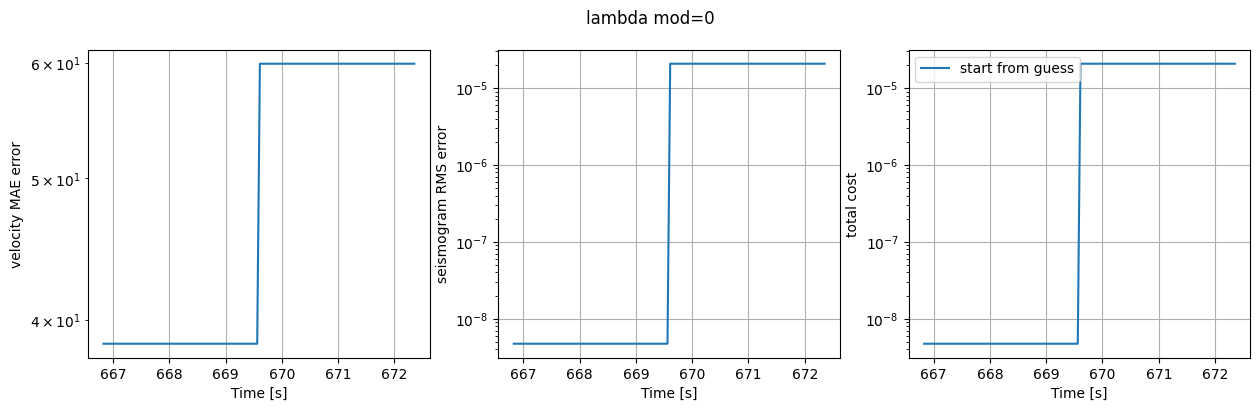

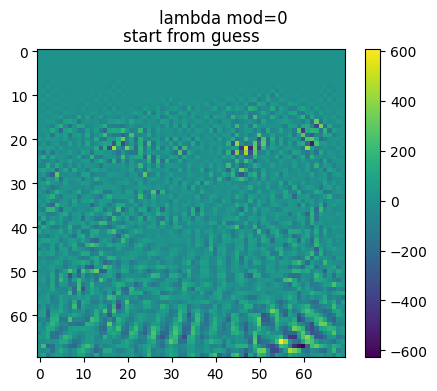

diag 1.6256417939039762e-05


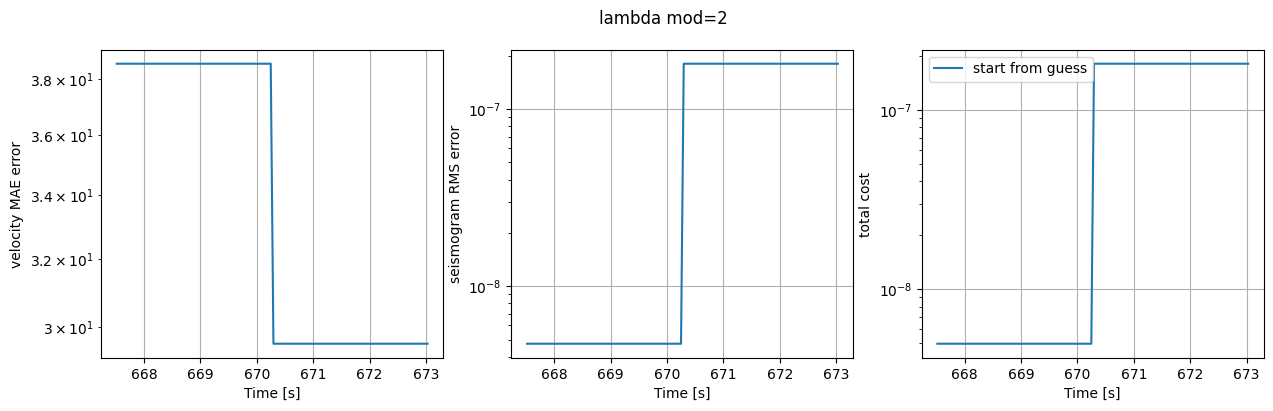

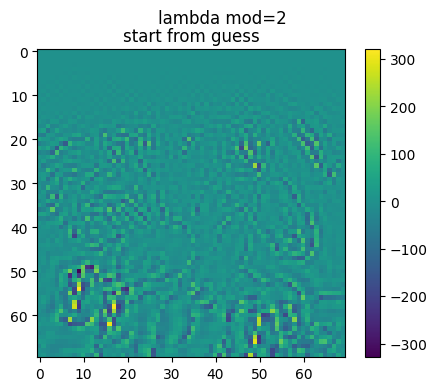

diag 1.6256417939039762e-05


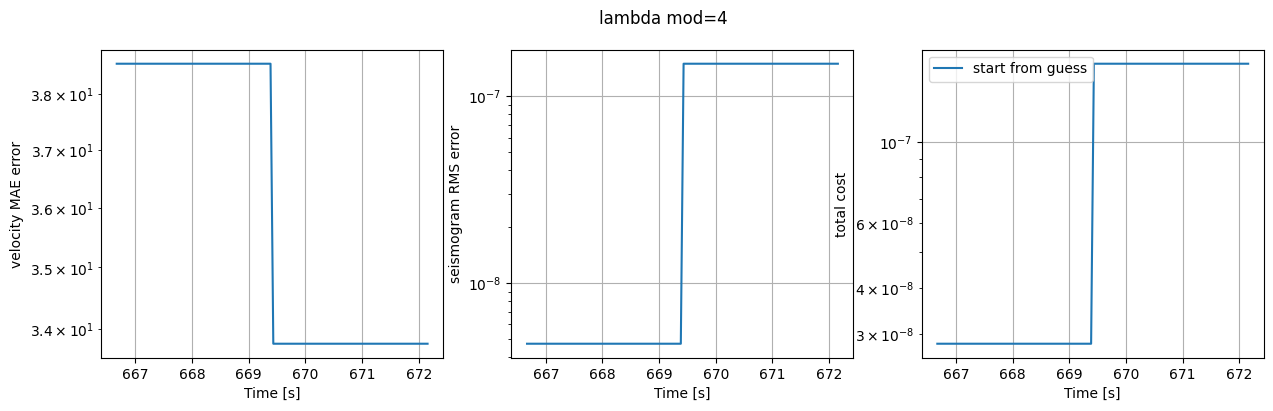

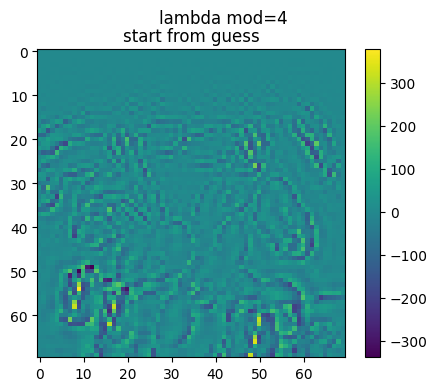

diag 1.6256417939039762e-05


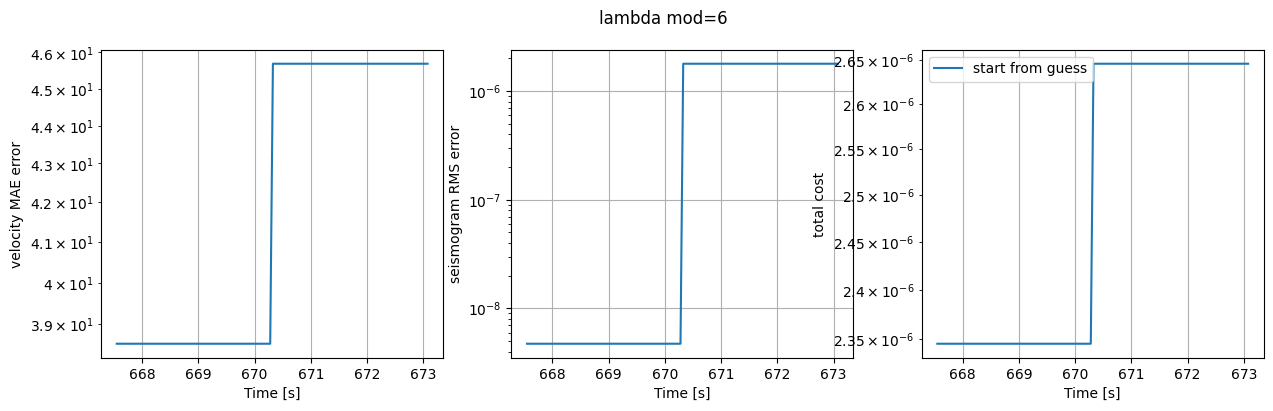

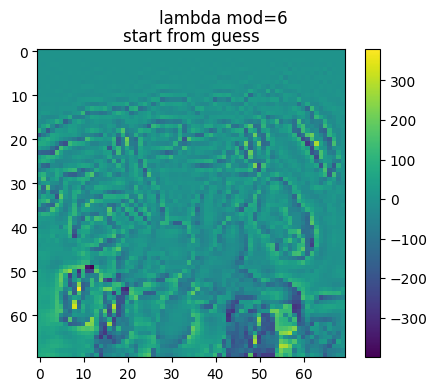

diag 1.6256417939039762e-05


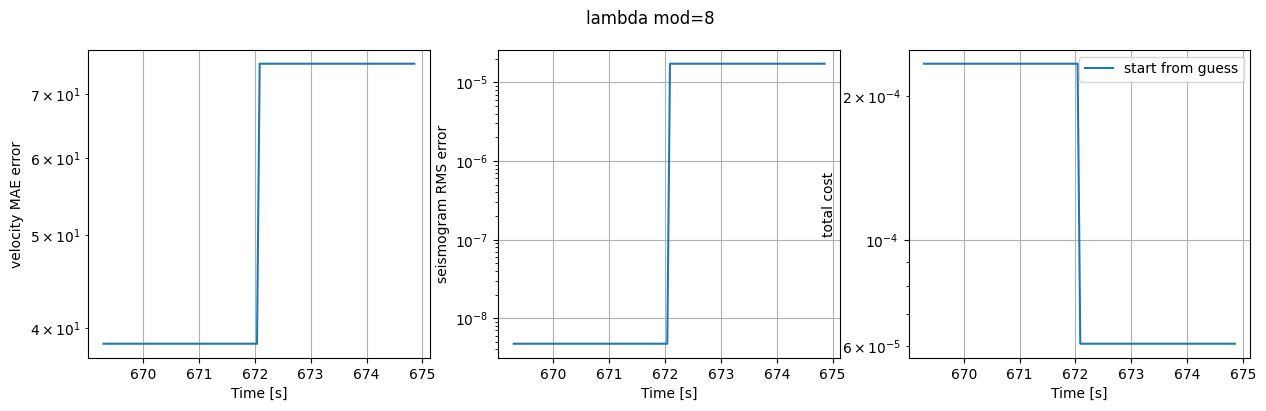

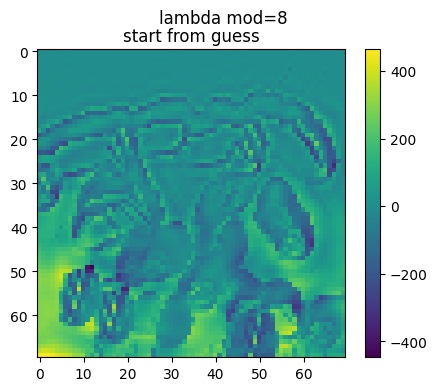

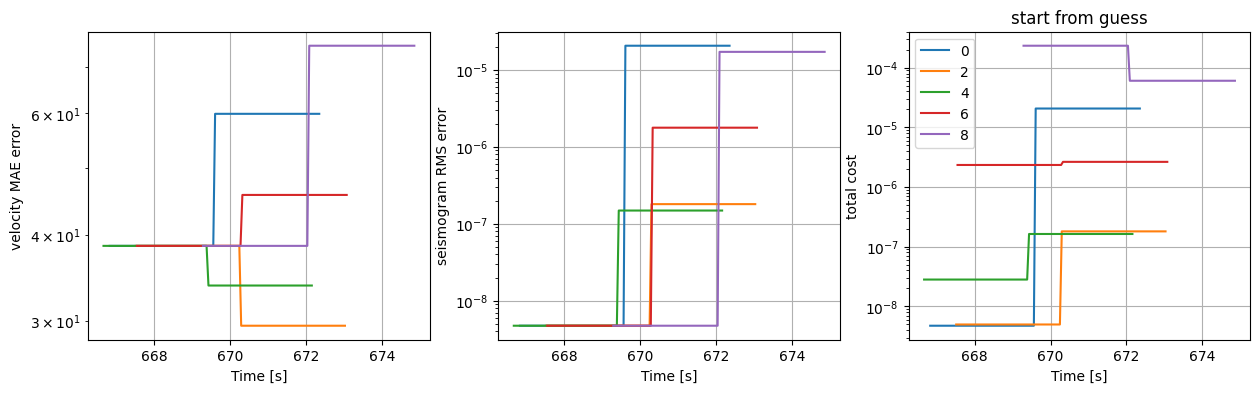

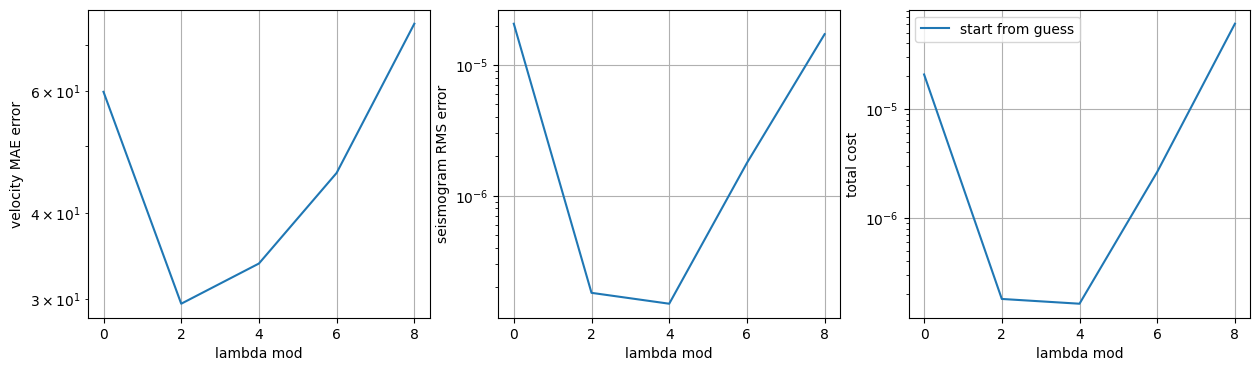

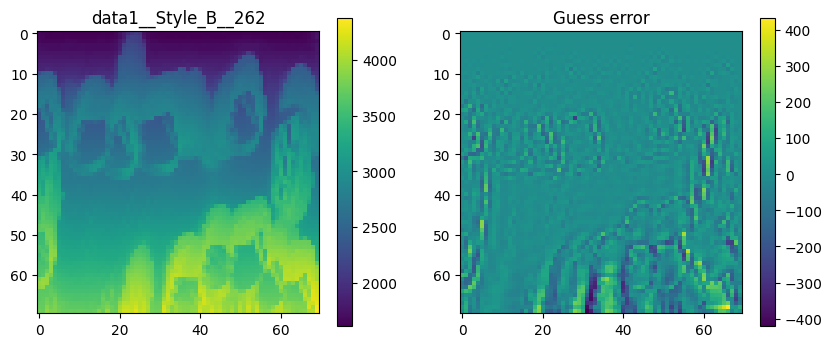

diag 2.1208179440339616e-05


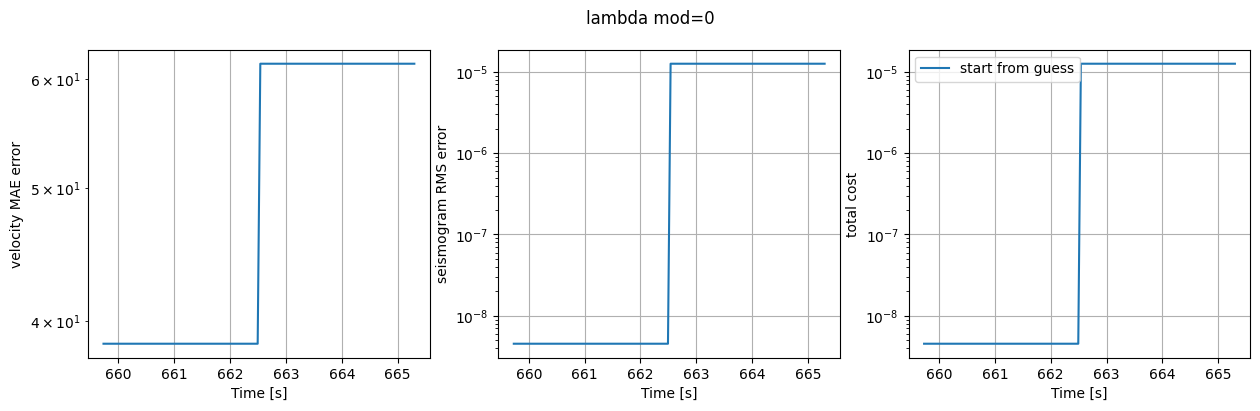

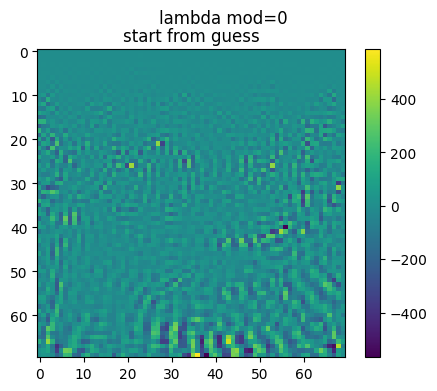

diag 2.1208179440339616e-05


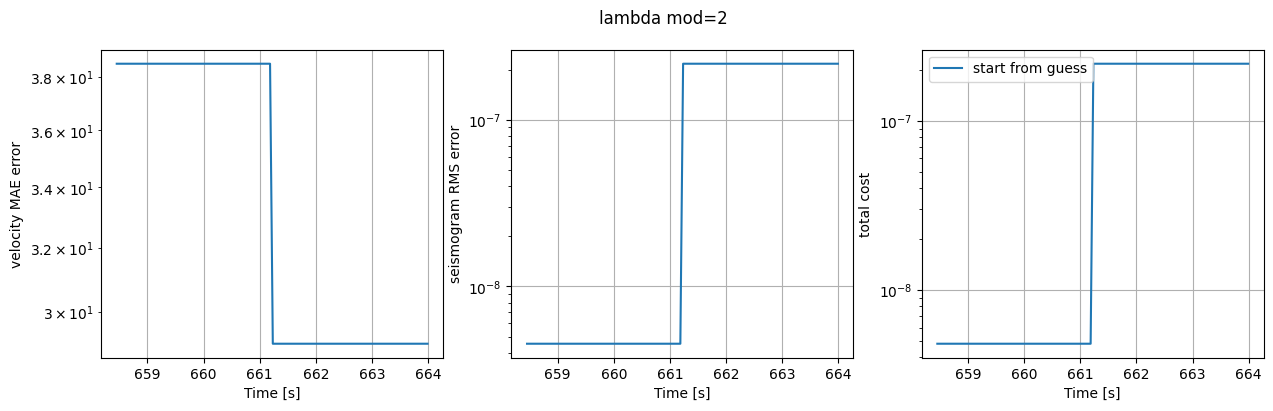

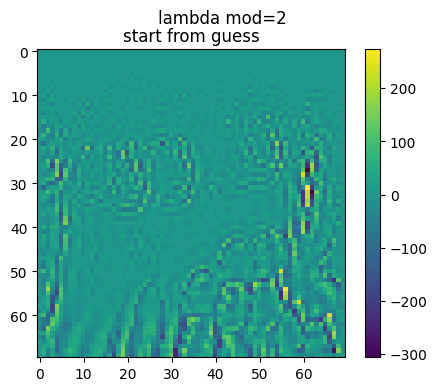

diag 2.1208179440339616e-05


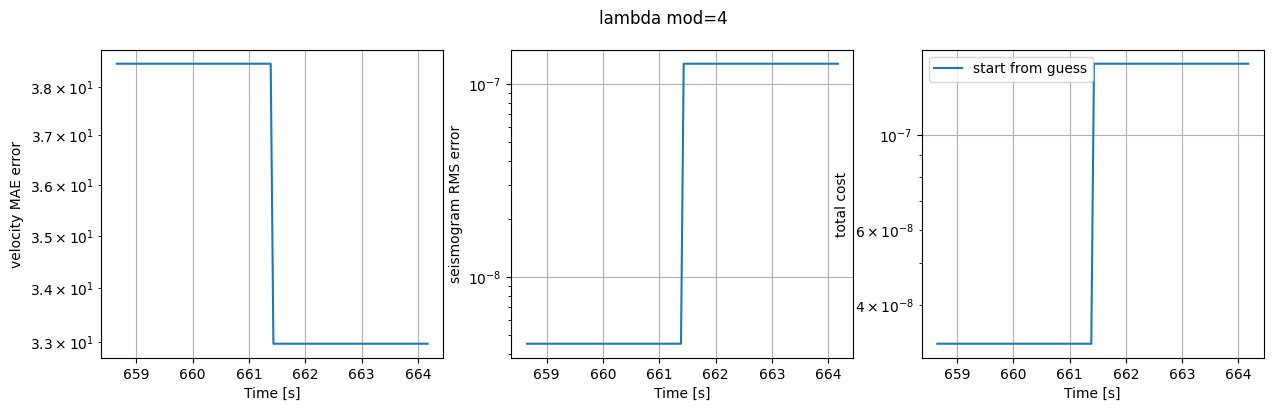

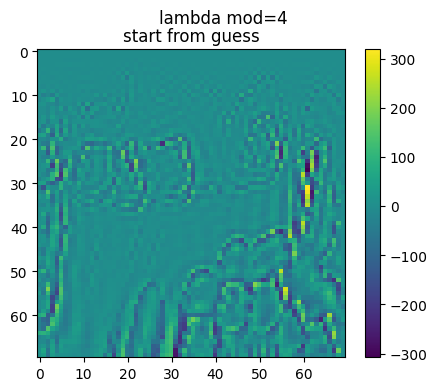

diag 2.1208179440339616e-05


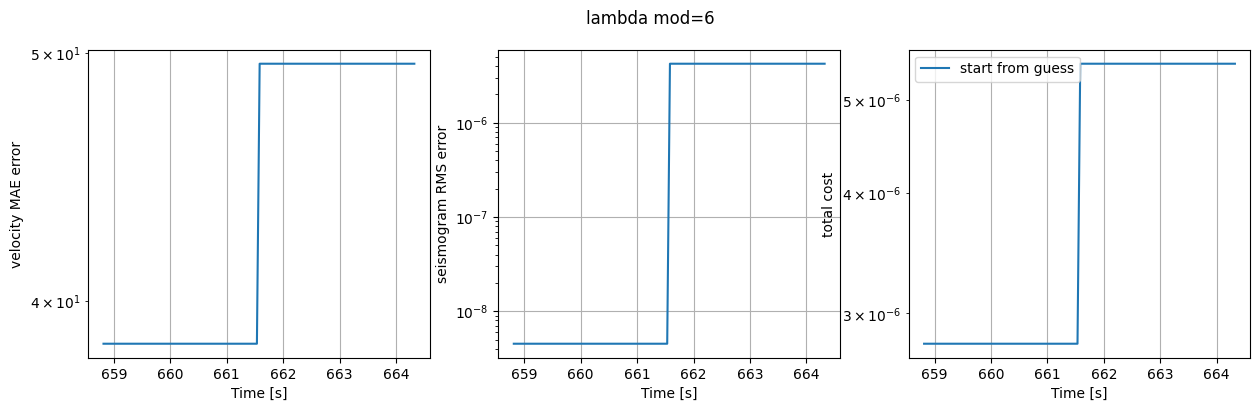

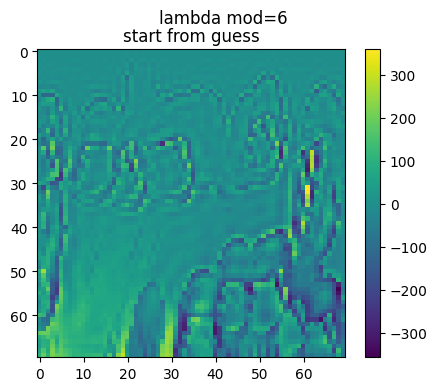

diag 2.1208179440339616e-05


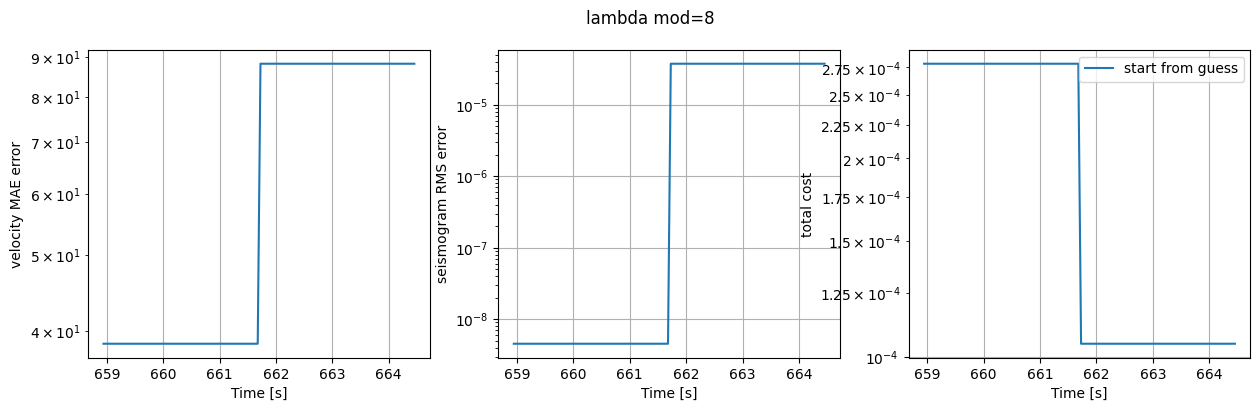

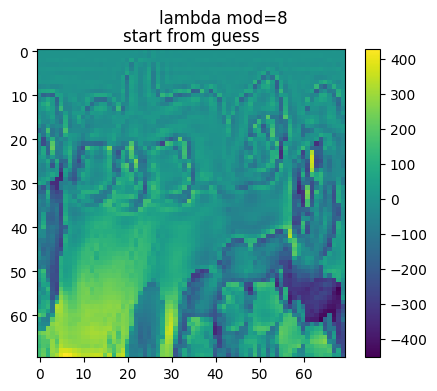

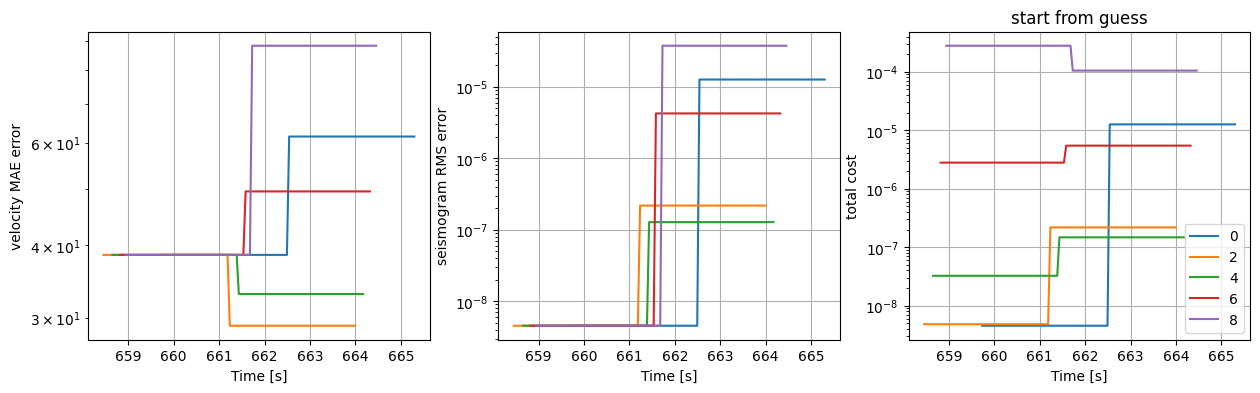

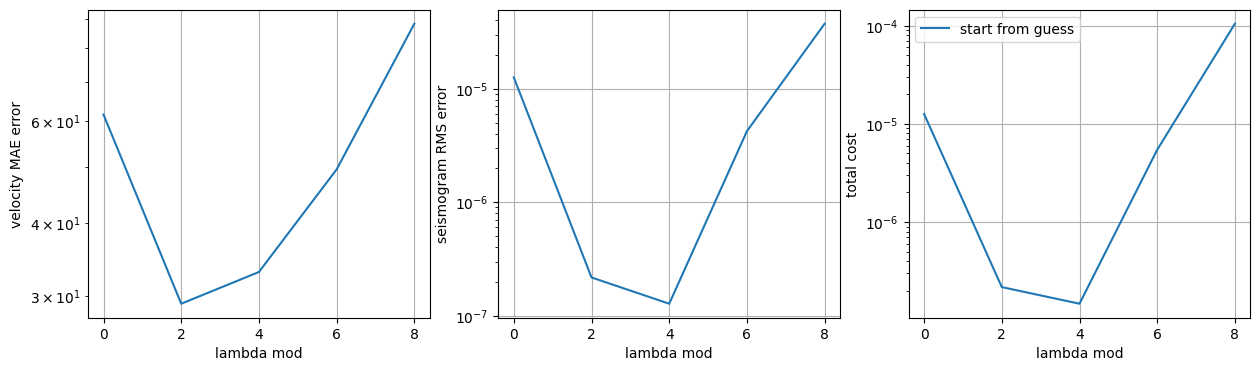

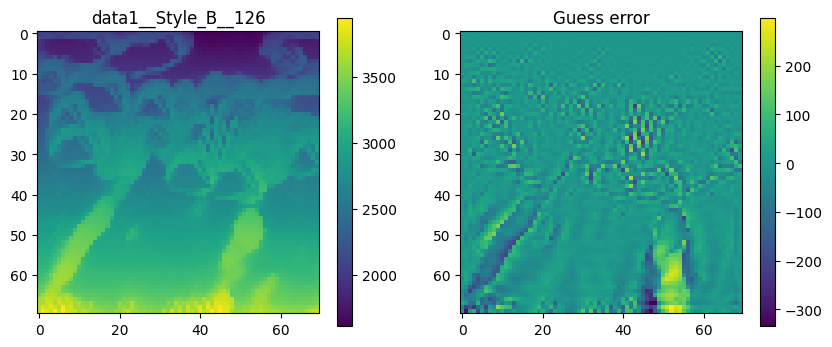

diag 2.457969740785111e-05


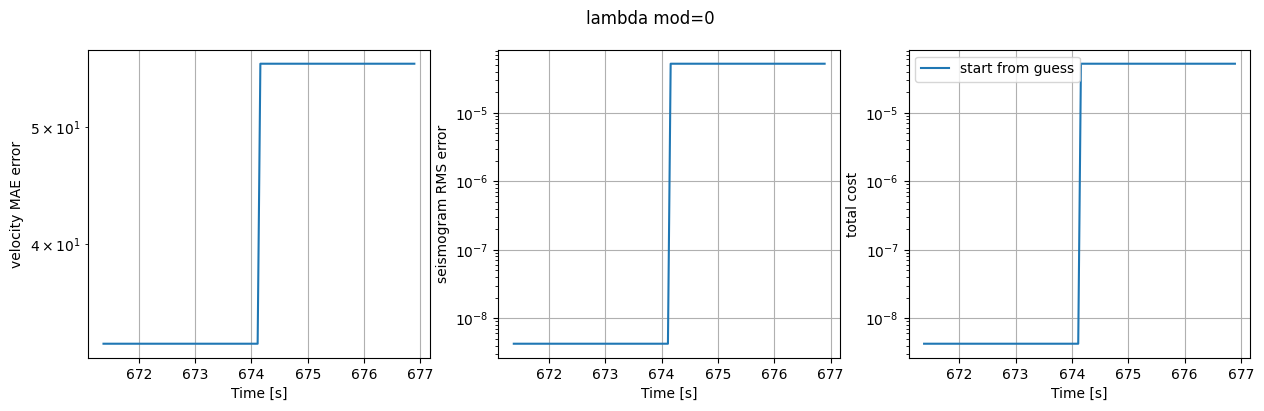

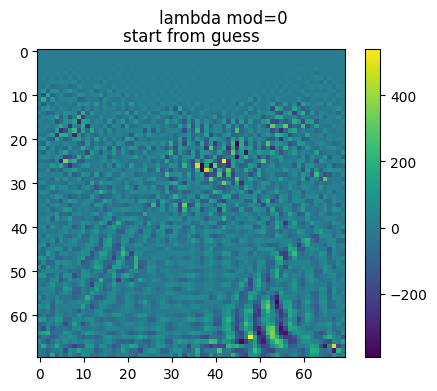

diag 2.457969740785111e-05


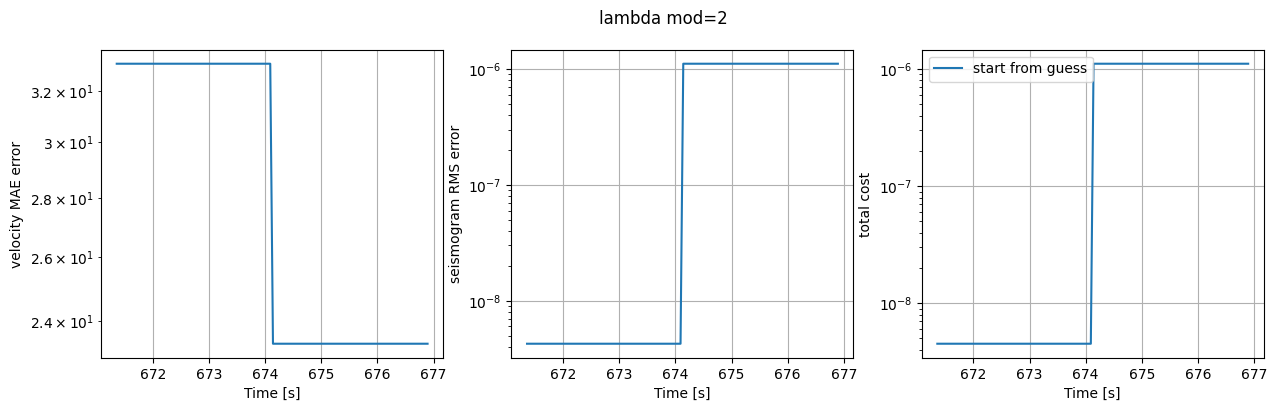

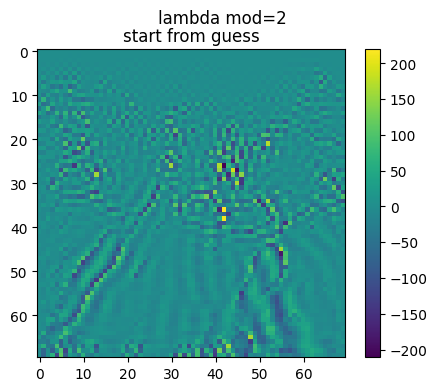

diag 2.457969740785111e-05


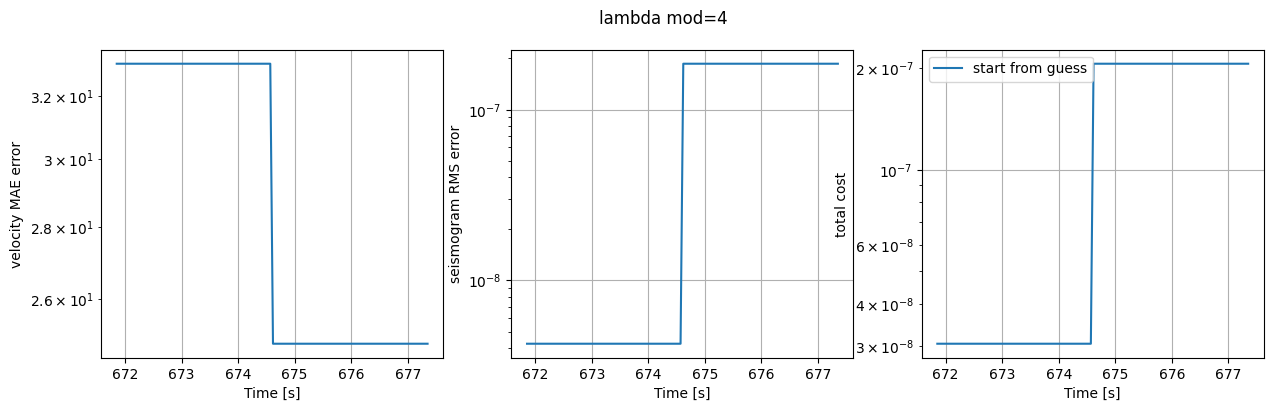

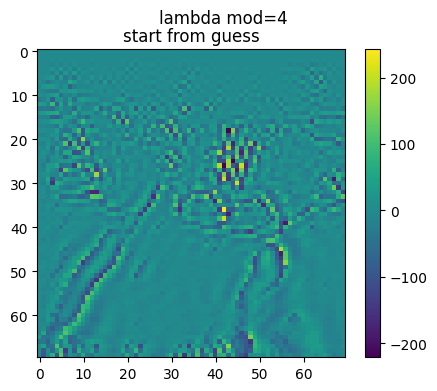

diag 2.457969740785111e-05


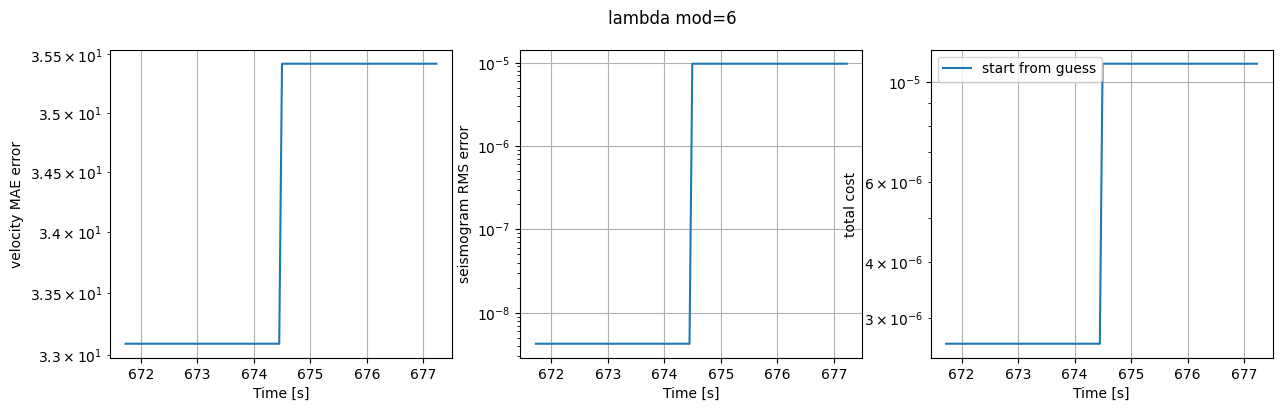

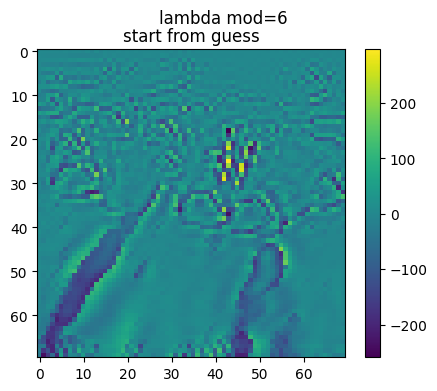

diag 2.457969740785111e-05


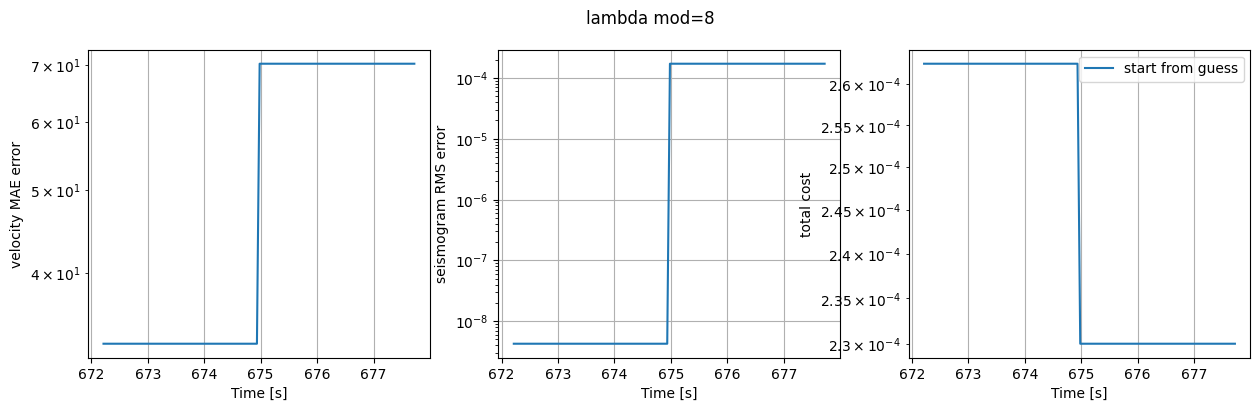

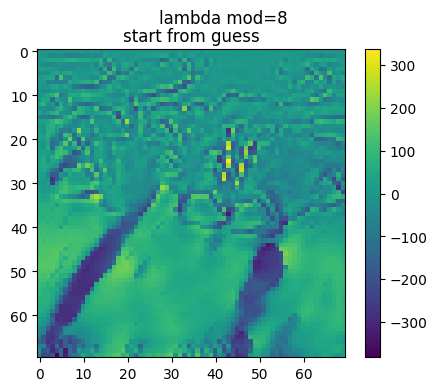

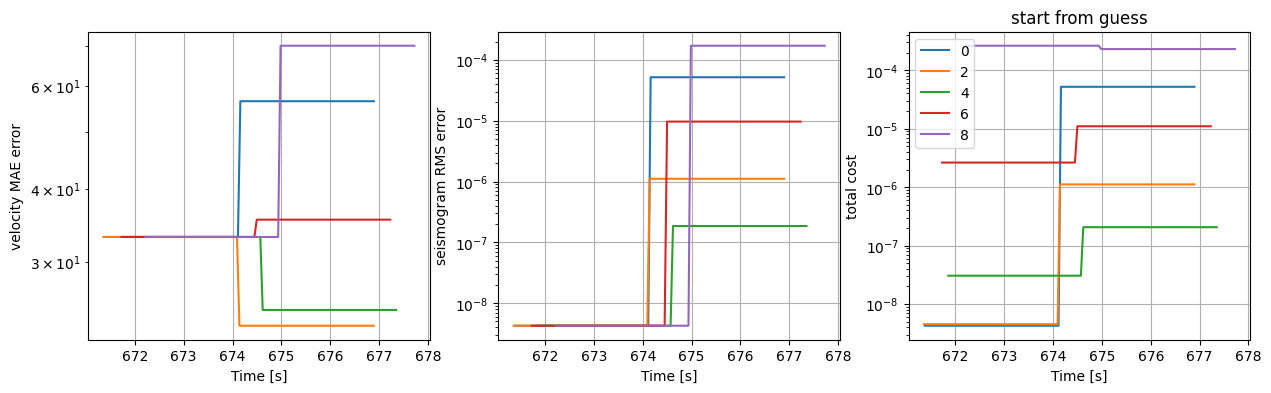

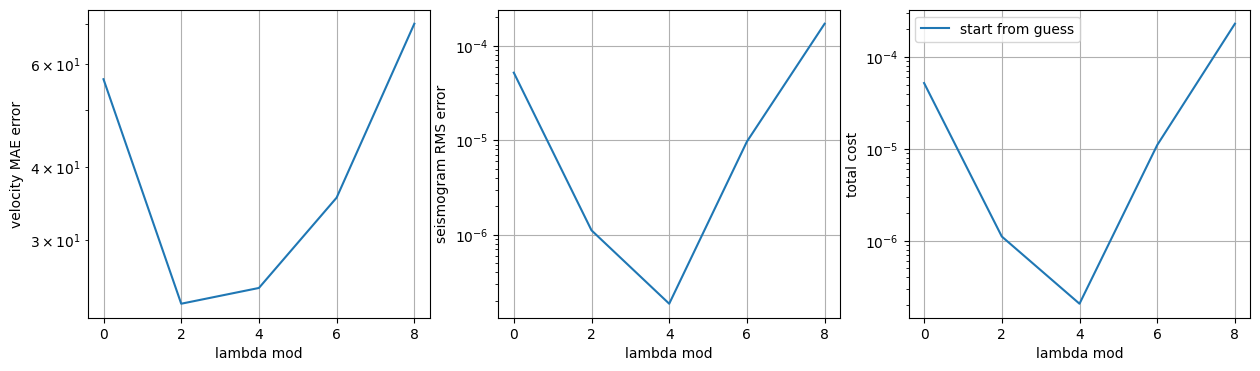

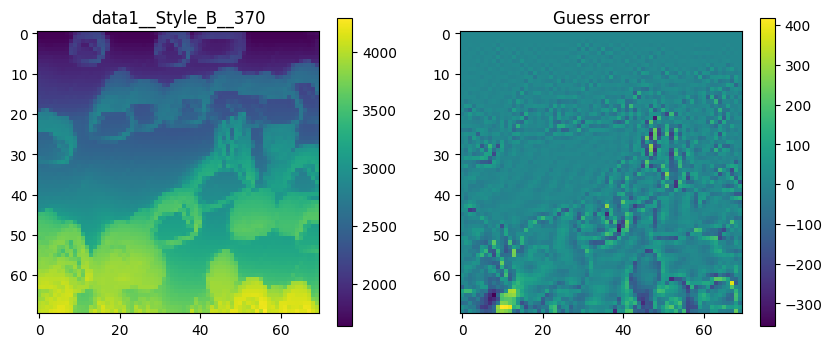

diag 1.5928753384472382e-05


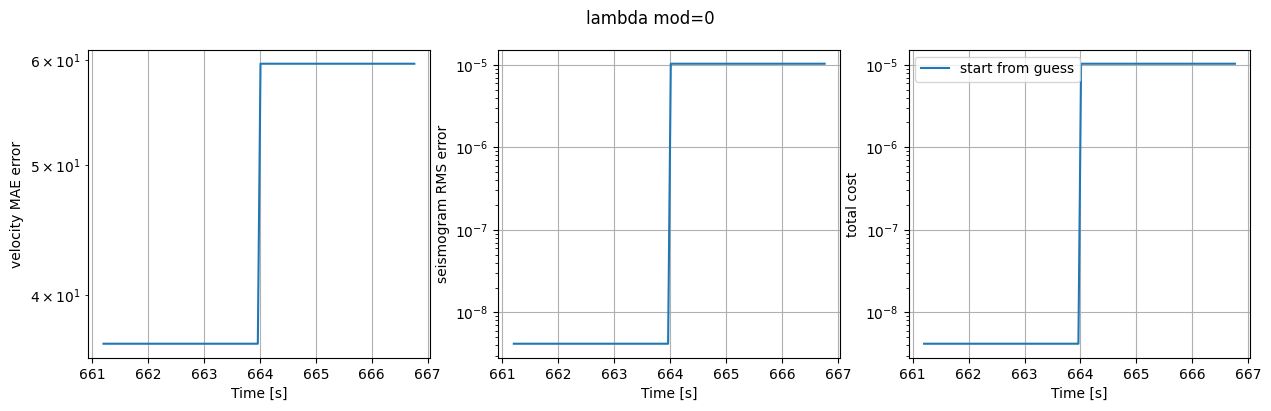

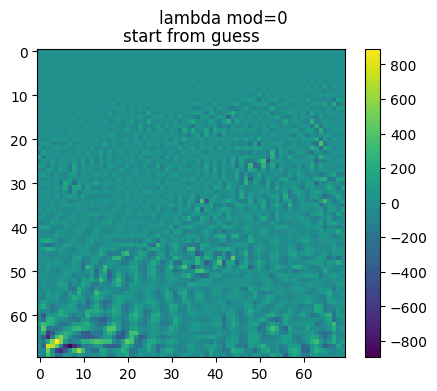

diag 1.5928753384472382e-05


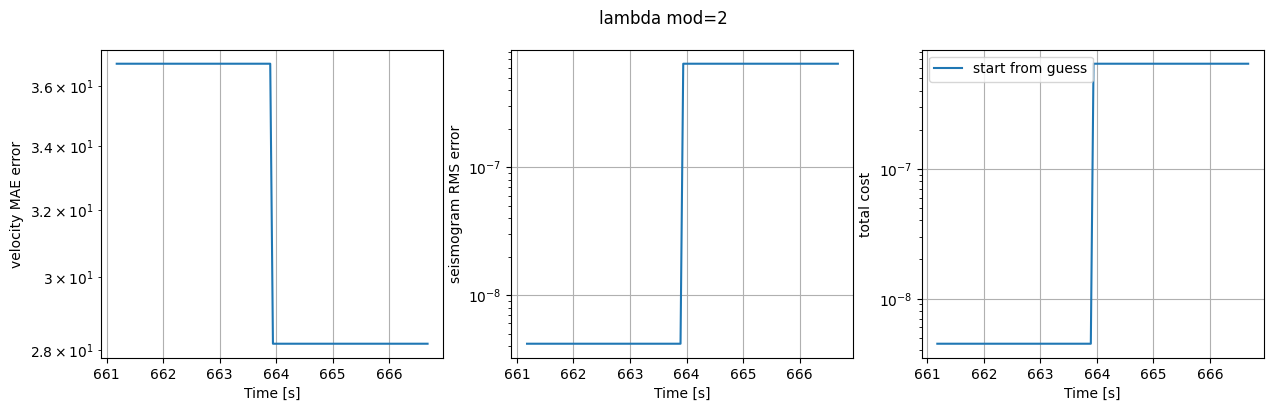

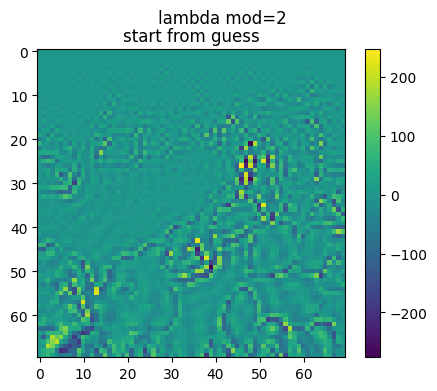

diag 1.5928753384472382e-05


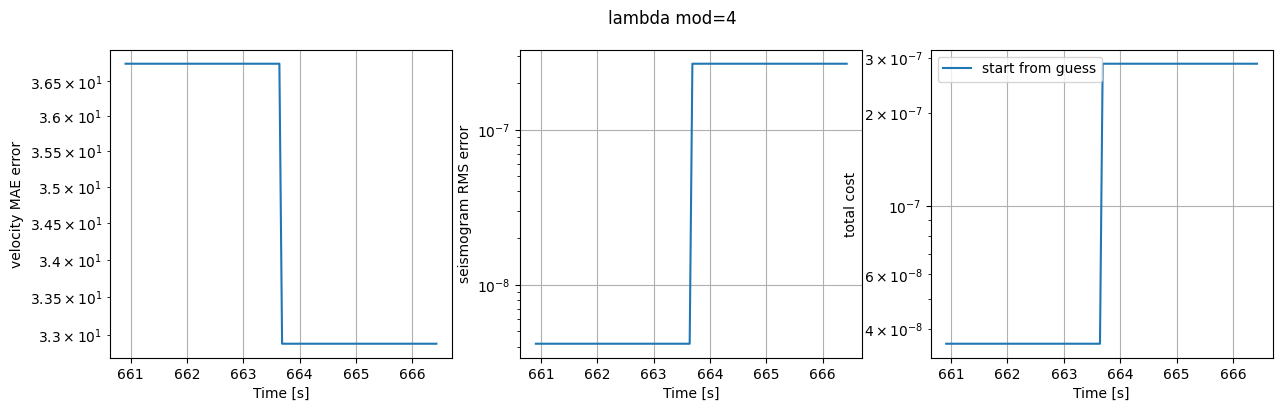

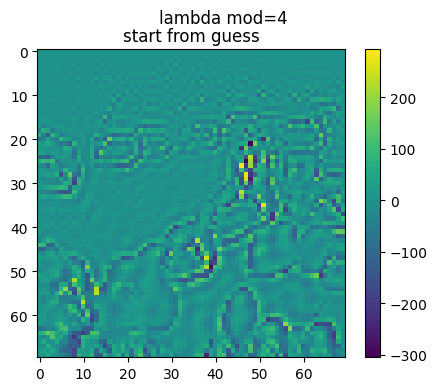

diag 1.5928753384472382e-05


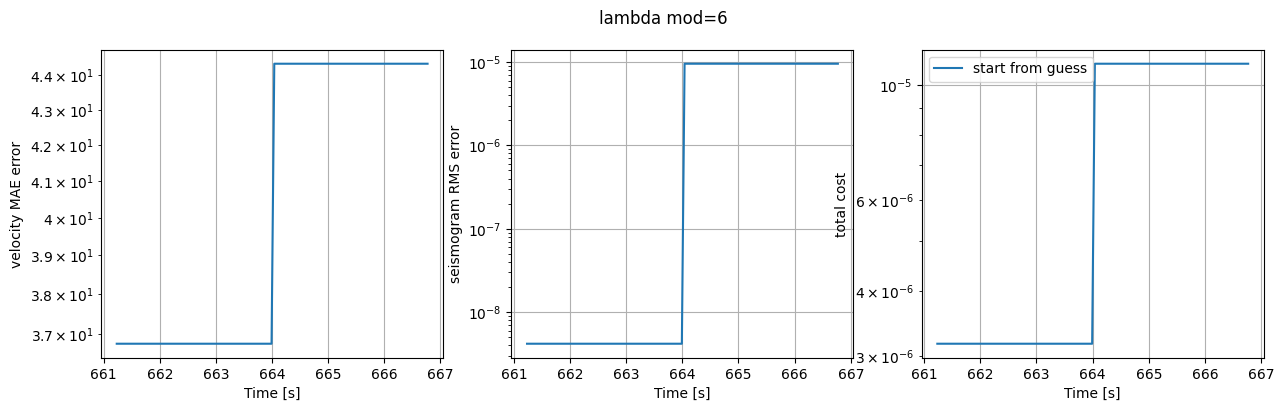

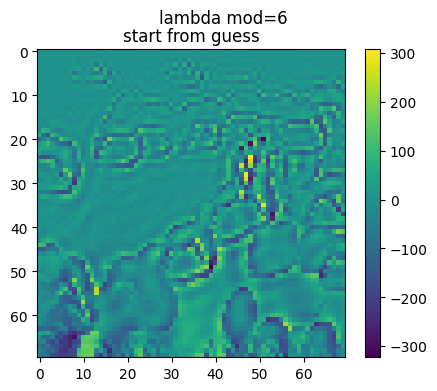

diag 1.5928753384472382e-05


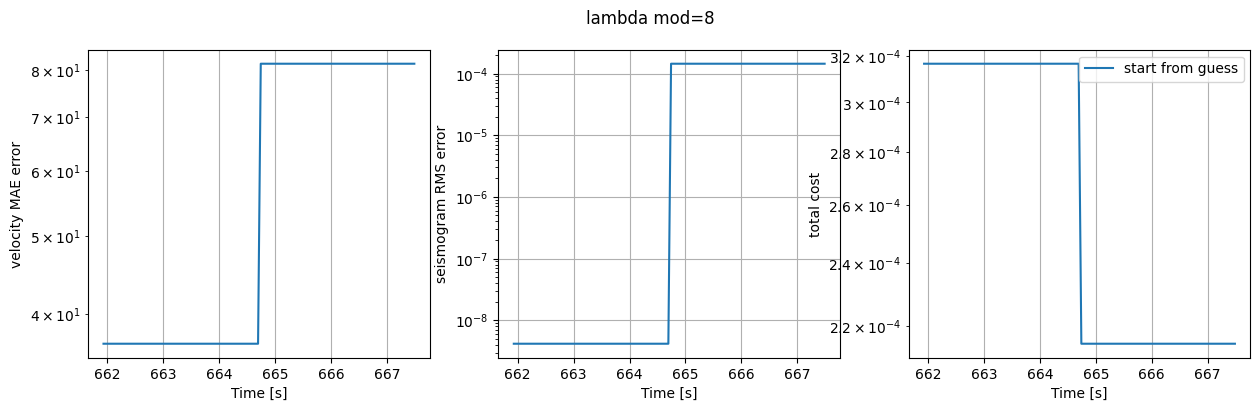

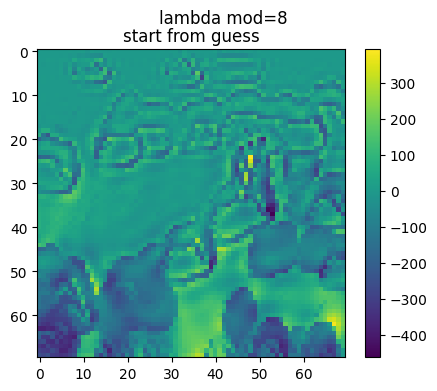

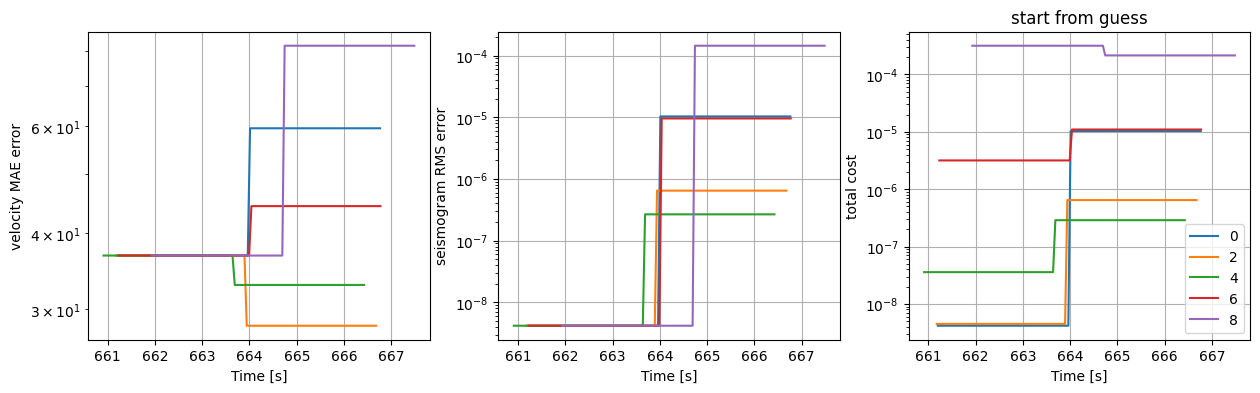

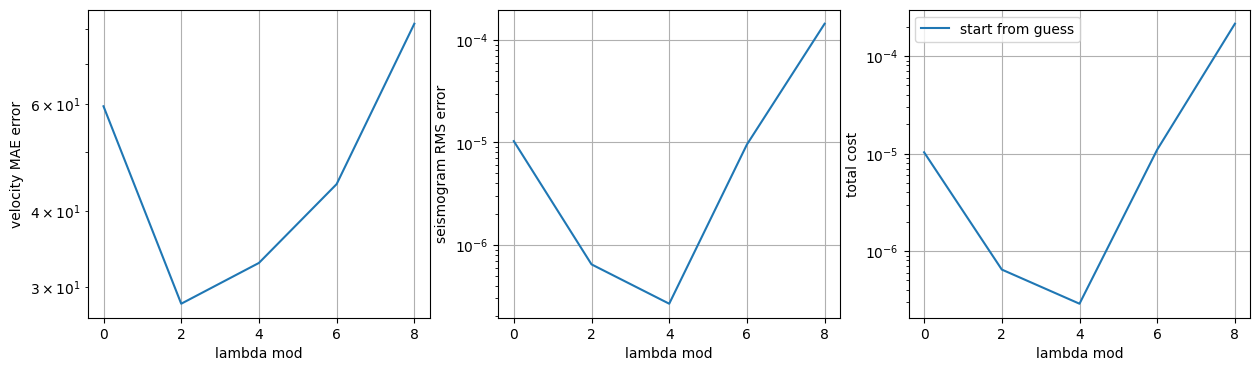

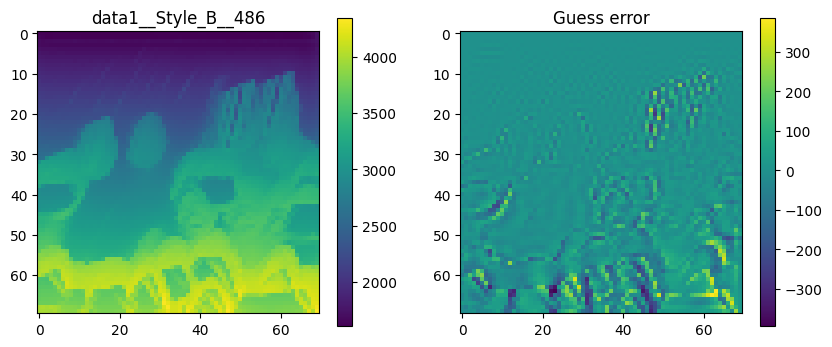

diag 2.528912352711953e-05


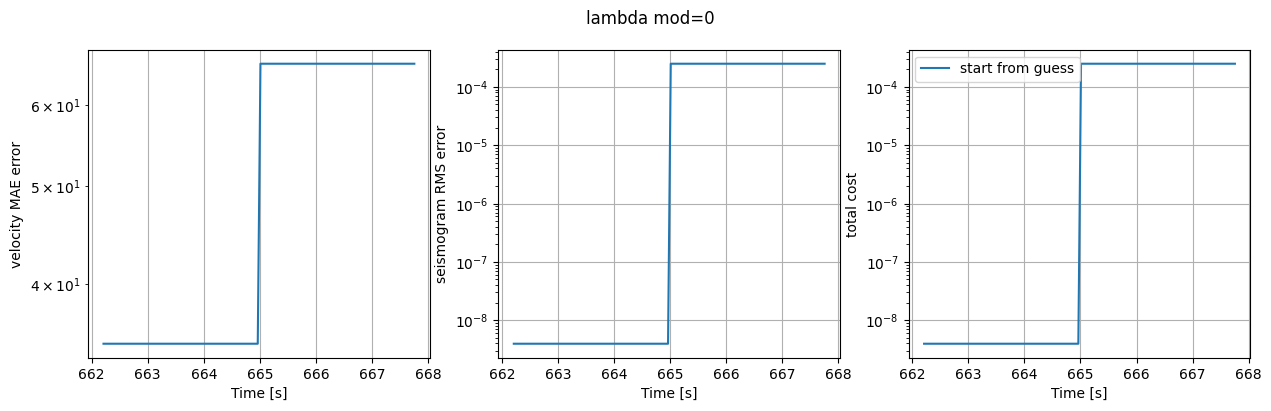

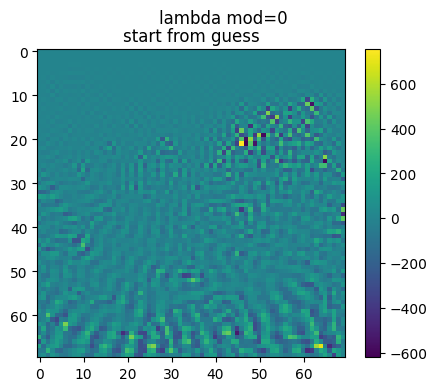

diag 2.528912352711953e-05


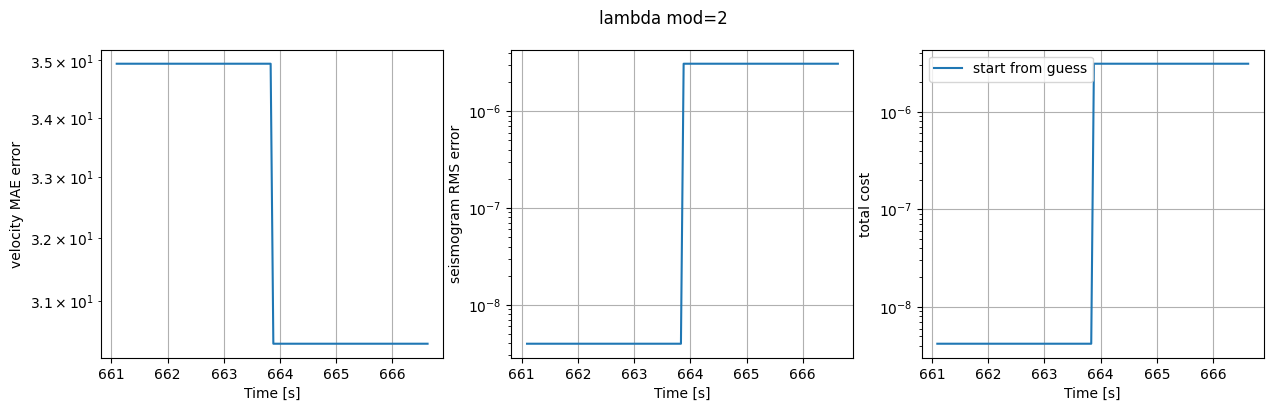

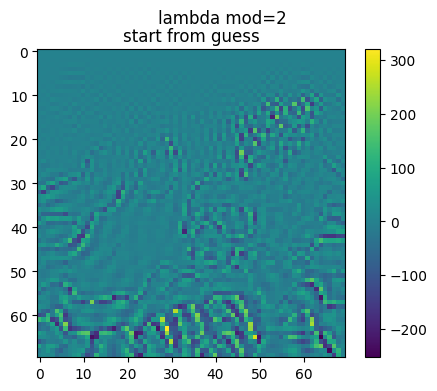

diag 2.528912352711953e-05


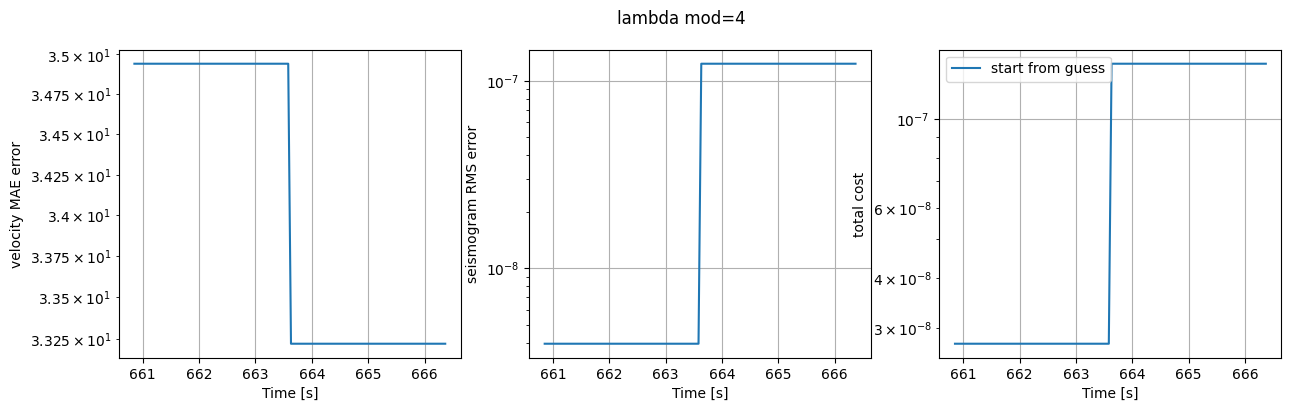

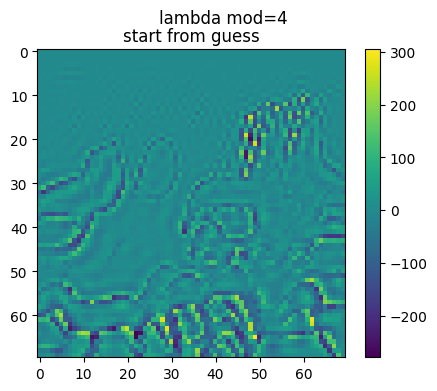

diag 2.528912352711953e-05


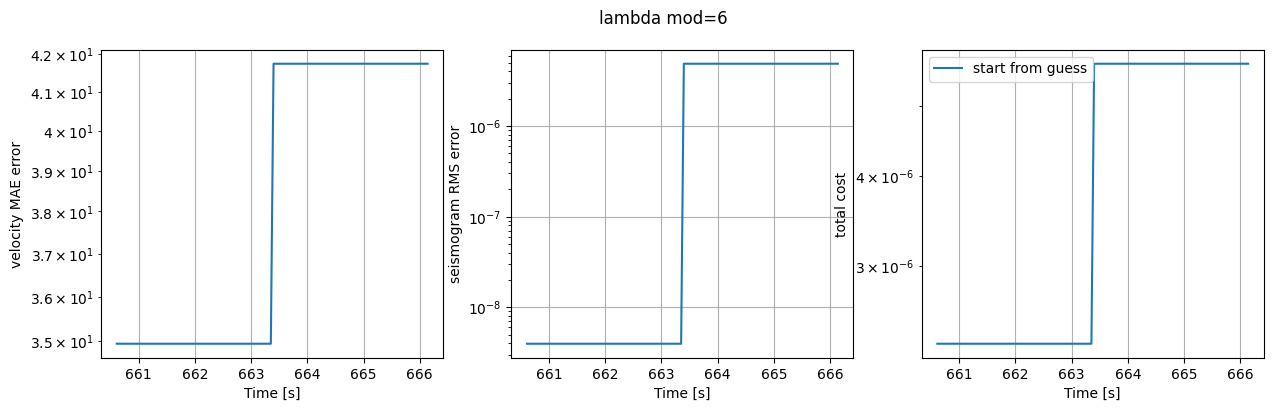

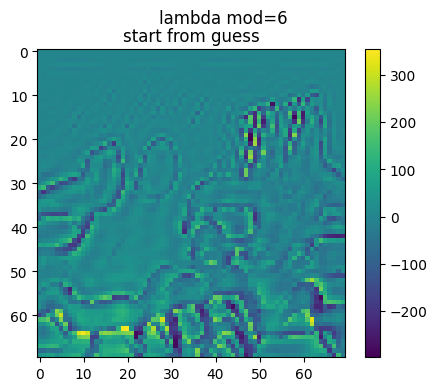

diag 2.528912352711953e-05


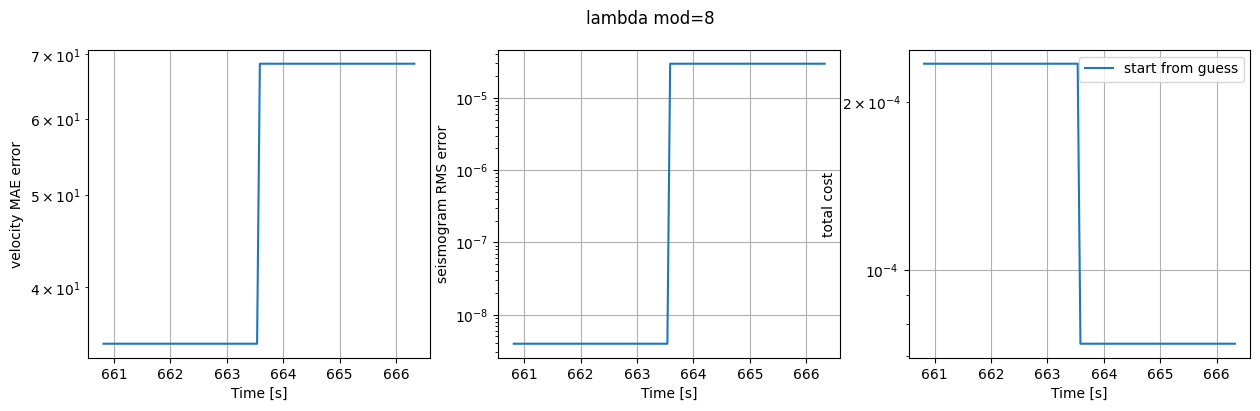

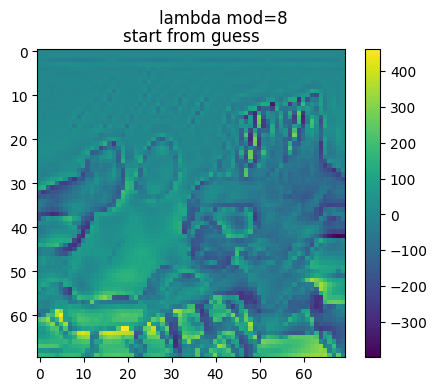

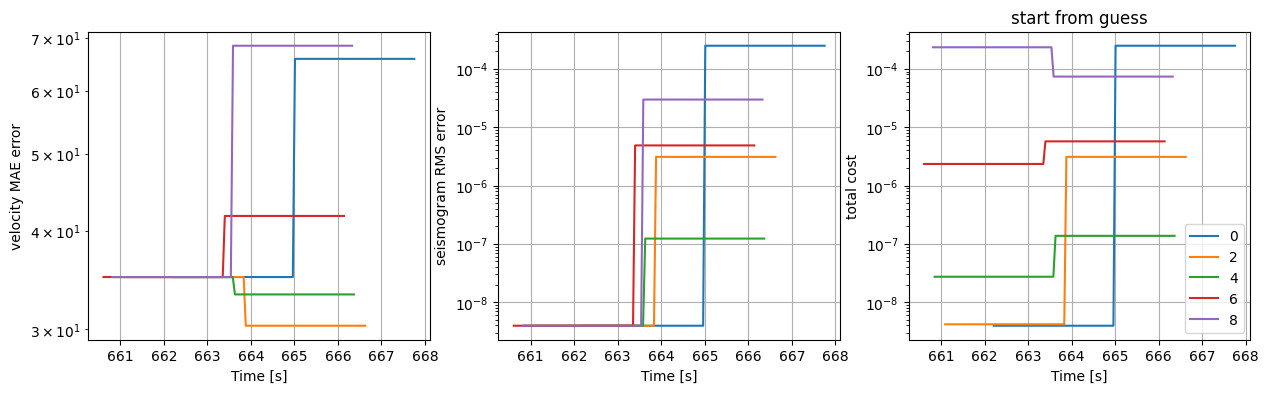

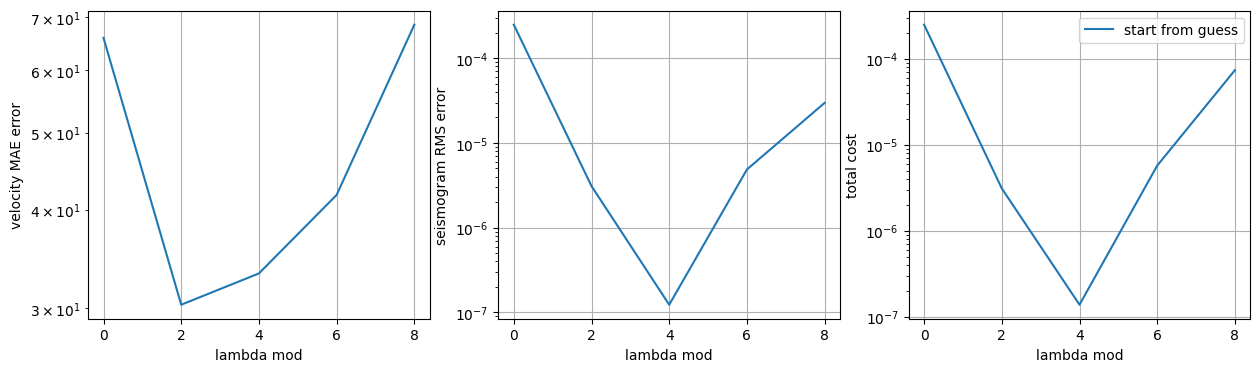

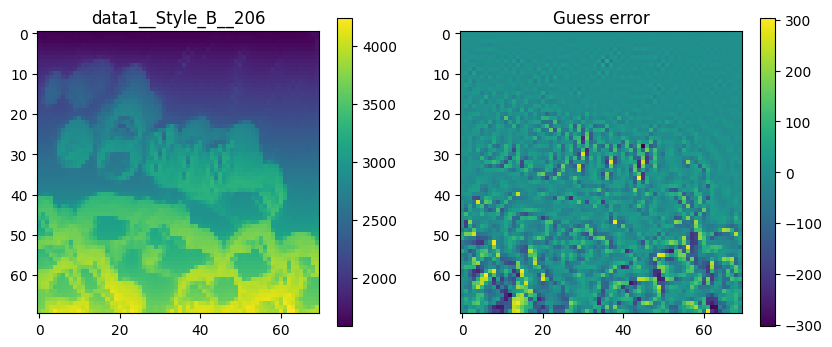

diag 1.6099335342891486e-05


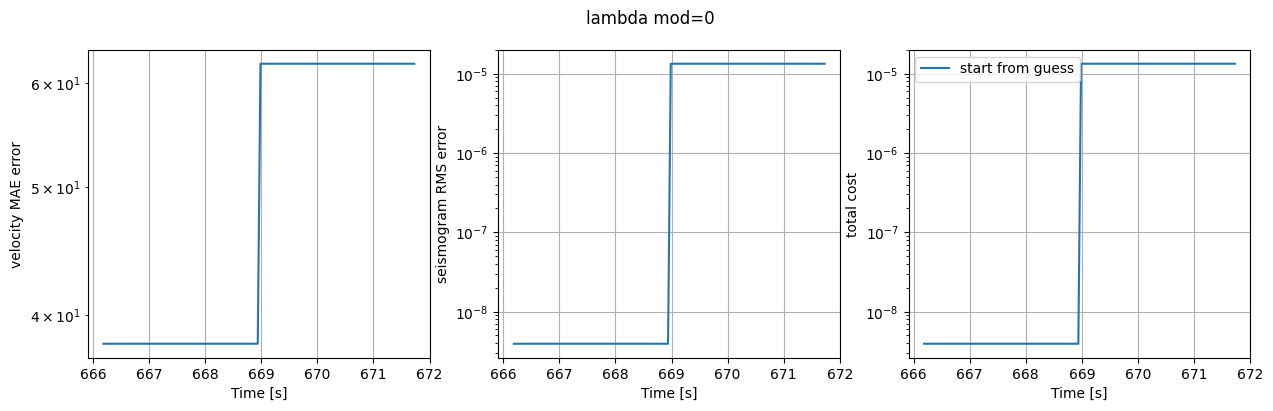

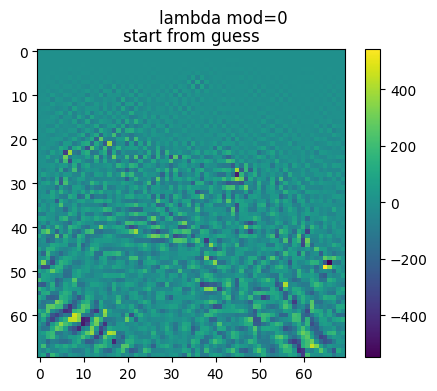

diag 1.6099335342891486e-05


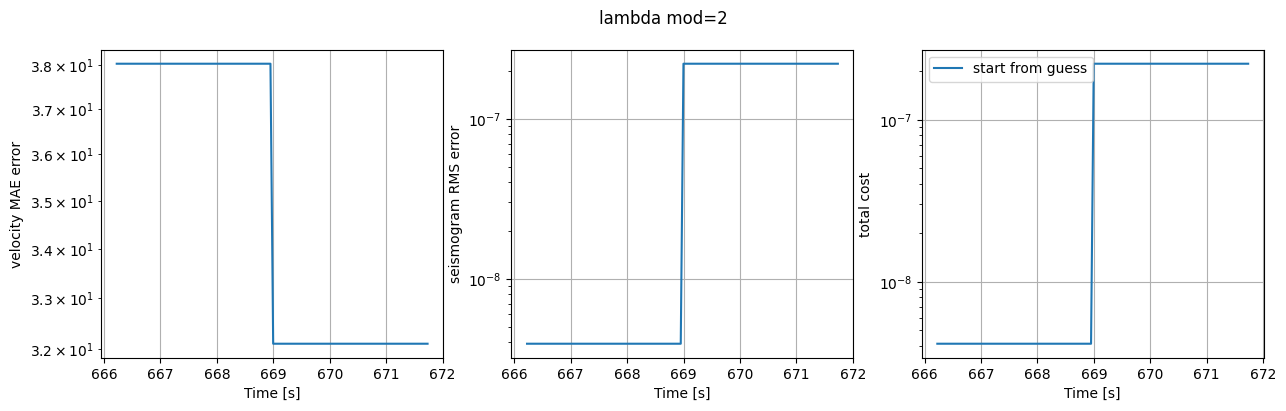

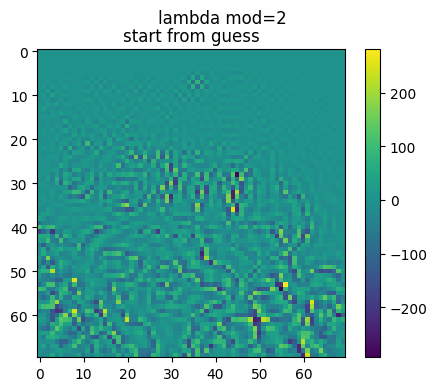

diag 1.6099335342891486e-05


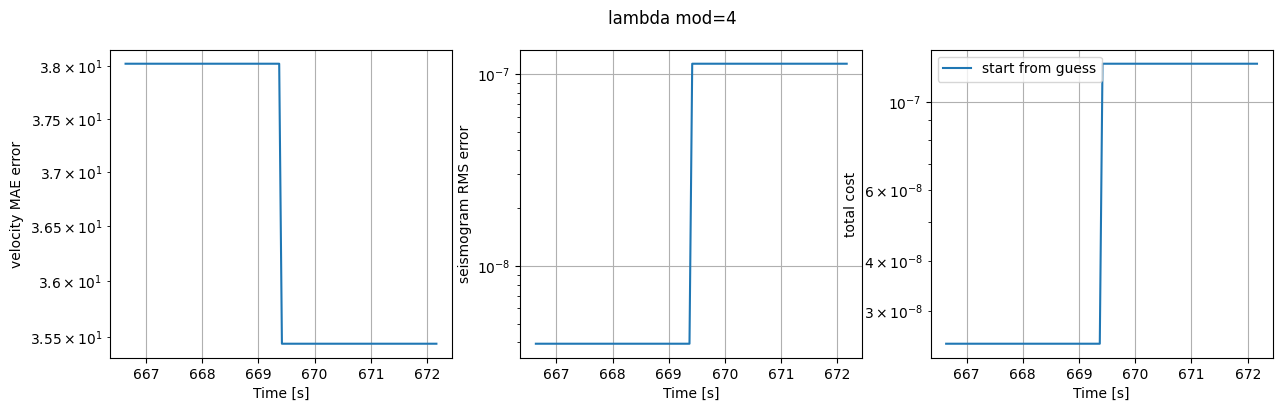

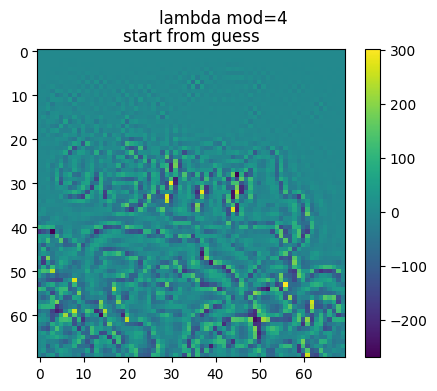

diag 1.6099335342891486e-05


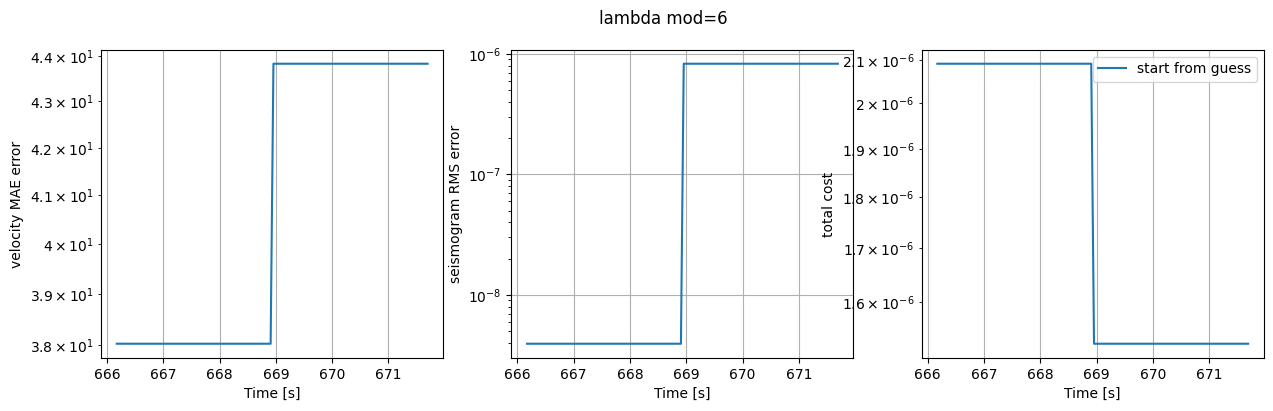

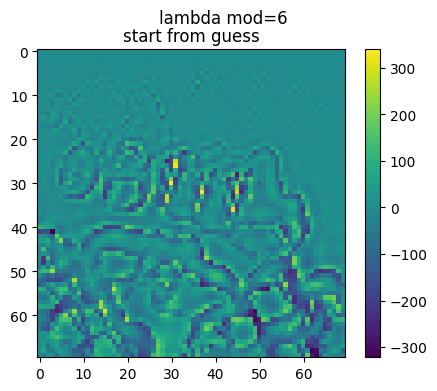

diag 1.6099335342891486e-05


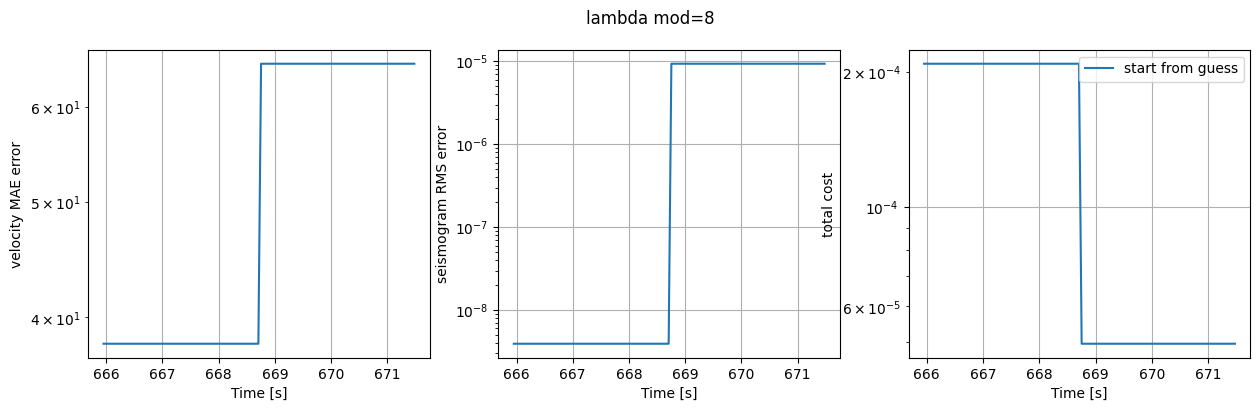

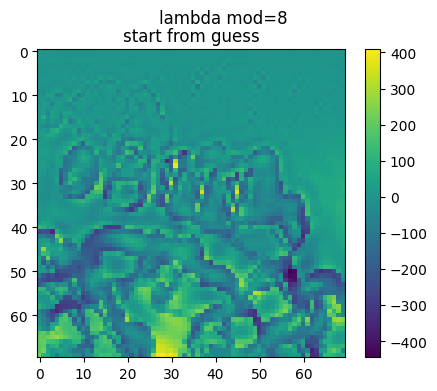

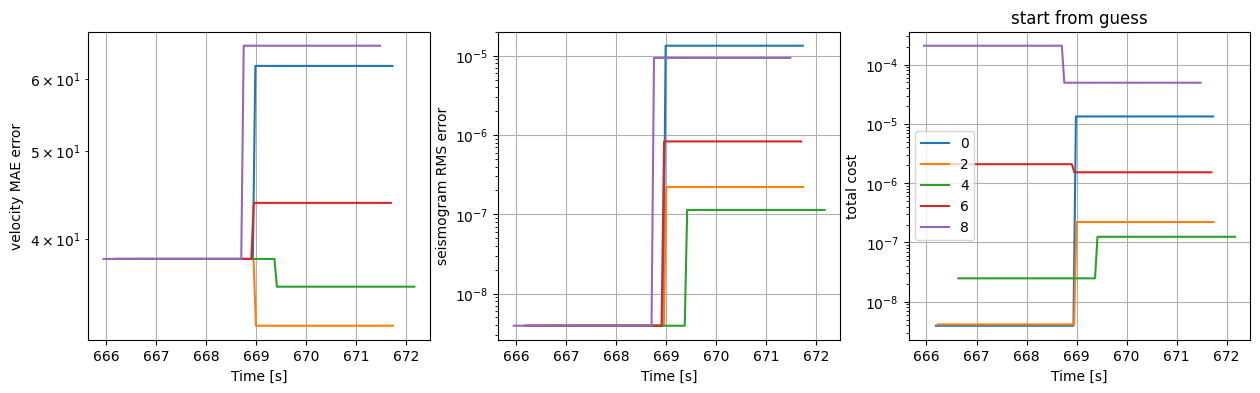

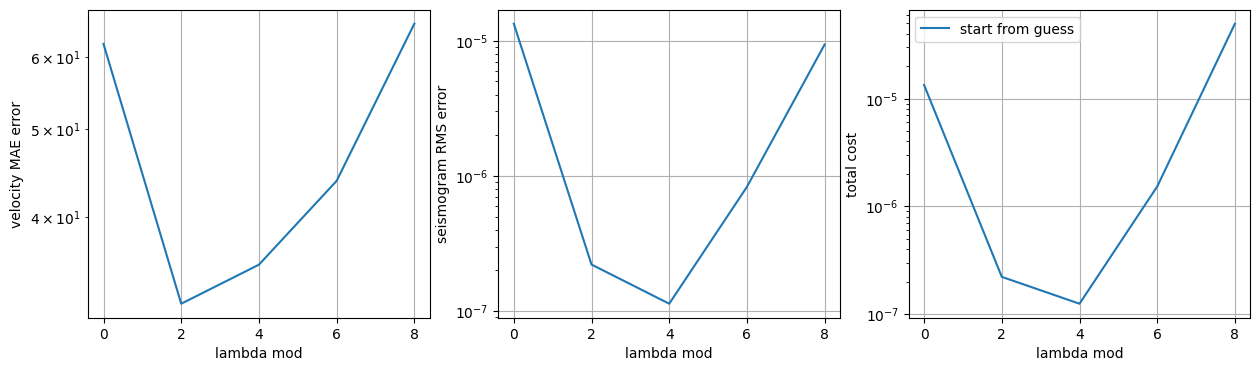

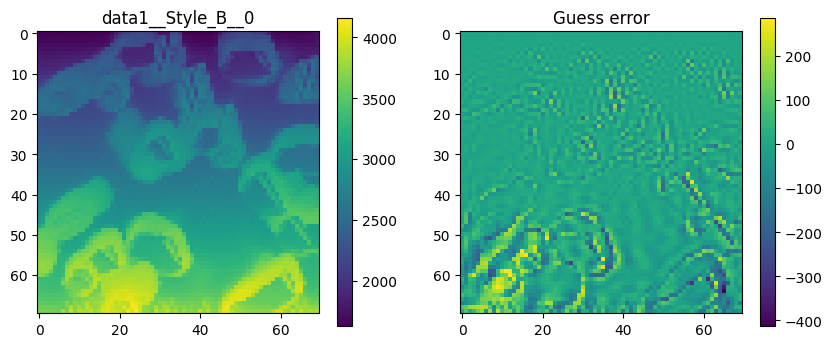

diag 1.4260362382528039e-05


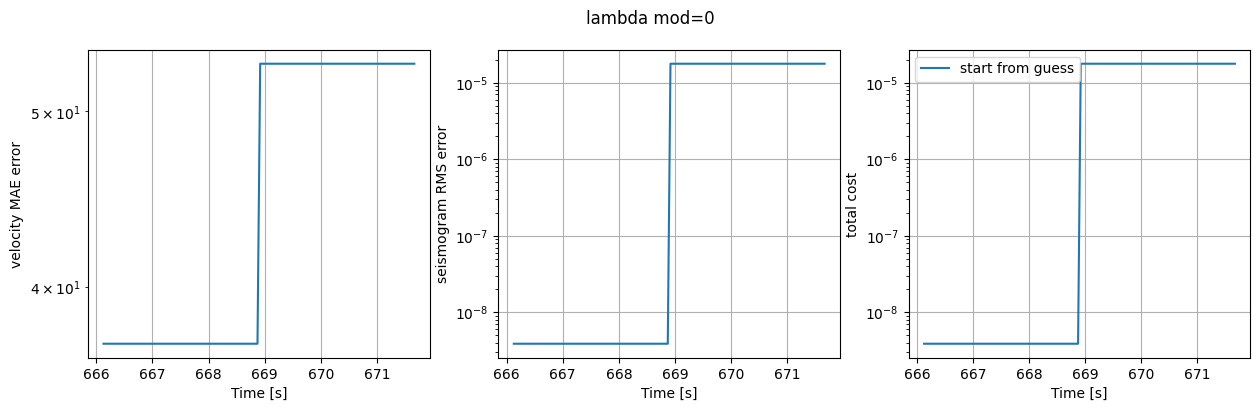

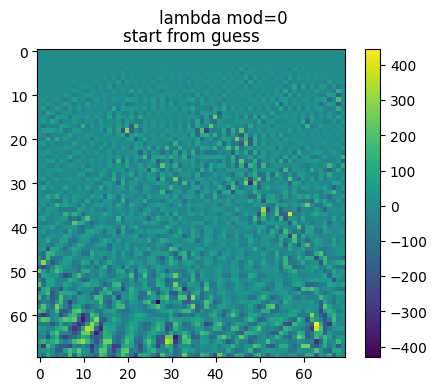

diag 1.4260362382528039e-05


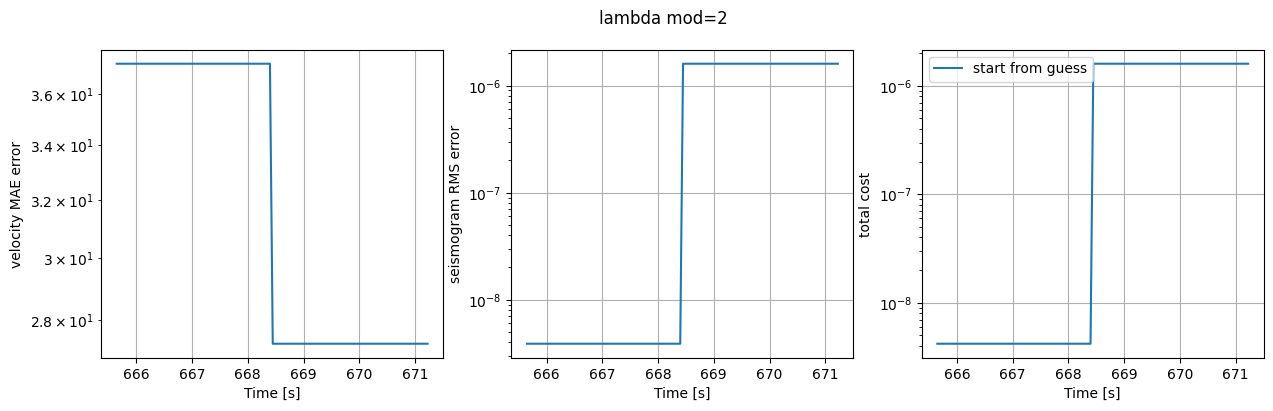

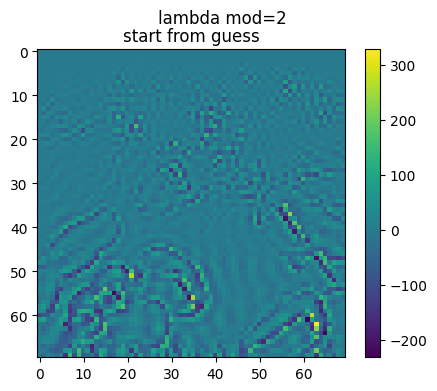

diag 1.4260362382528039e-05


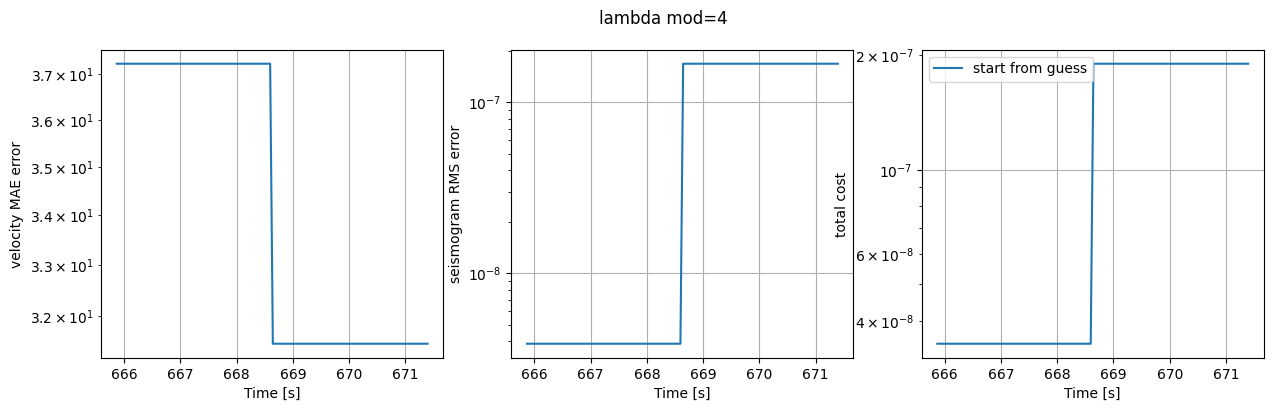

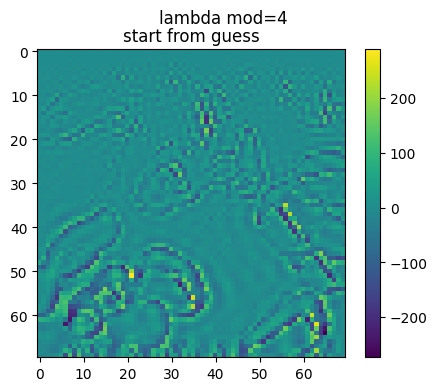

diag 1.4260362382528039e-05


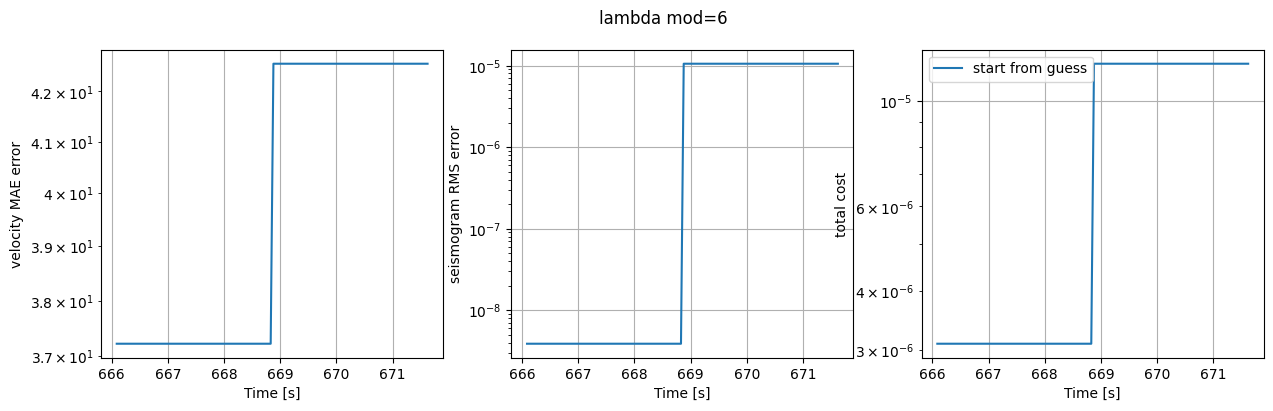

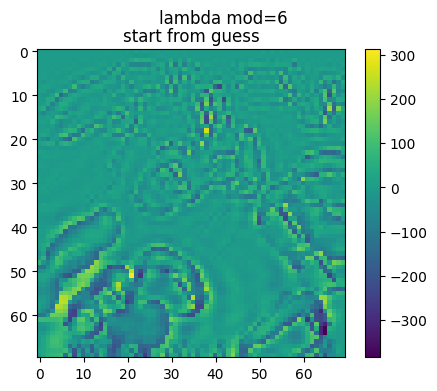

diag 1.4260362382528039e-05


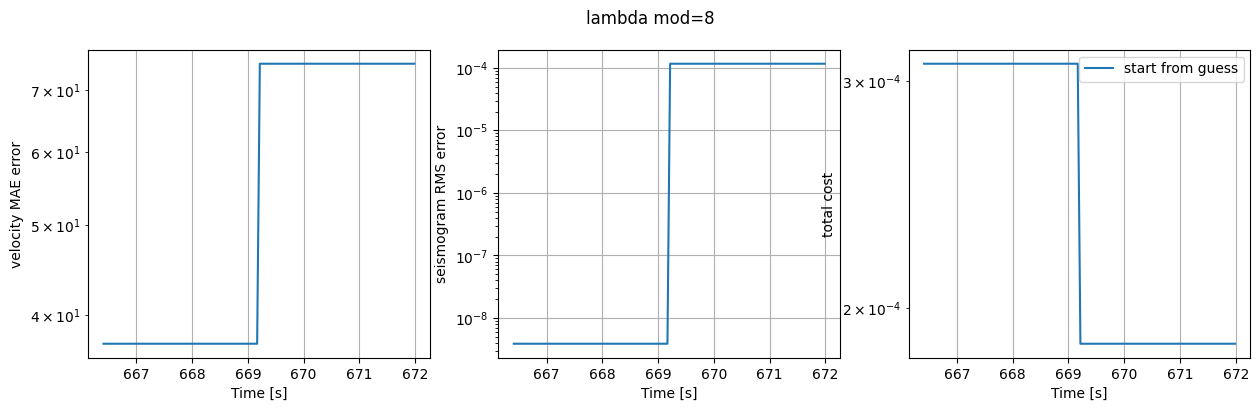

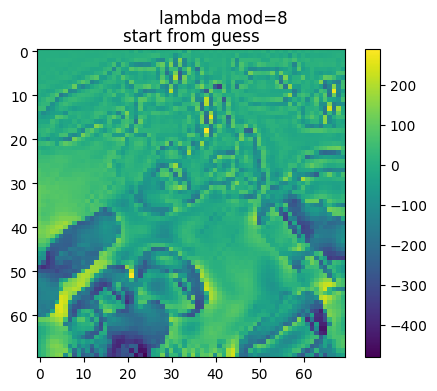

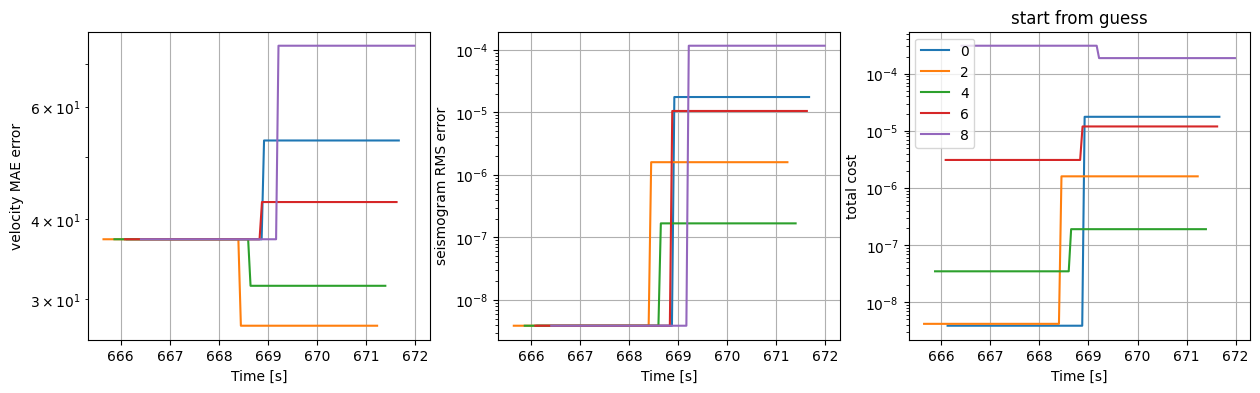

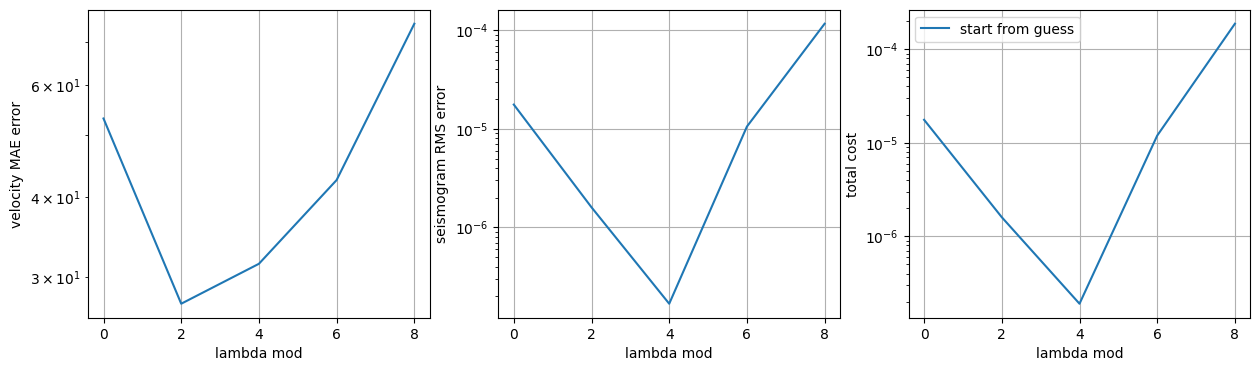

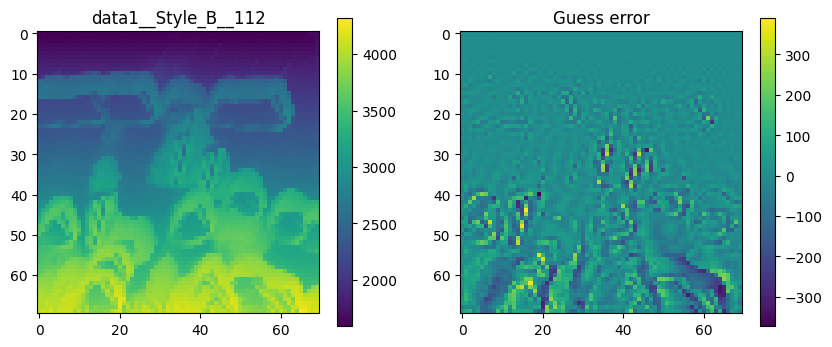

diag 1.4725289210368968e-05


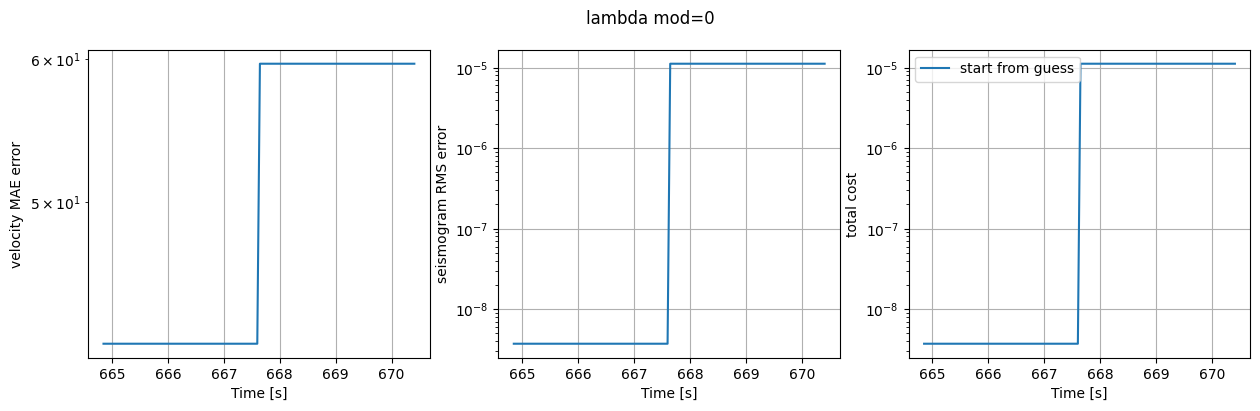

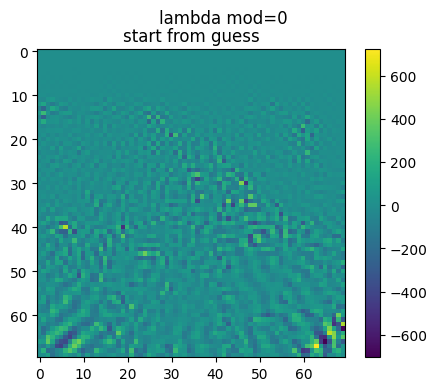

diag 1.4725289210368968e-05


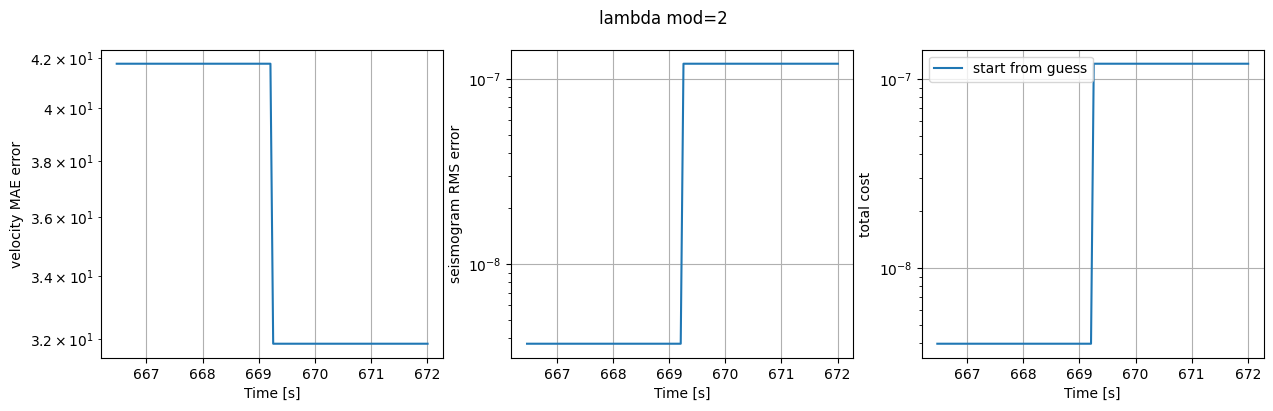

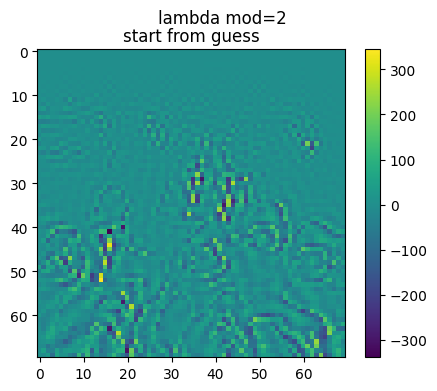

diag 1.4725289210368968e-05


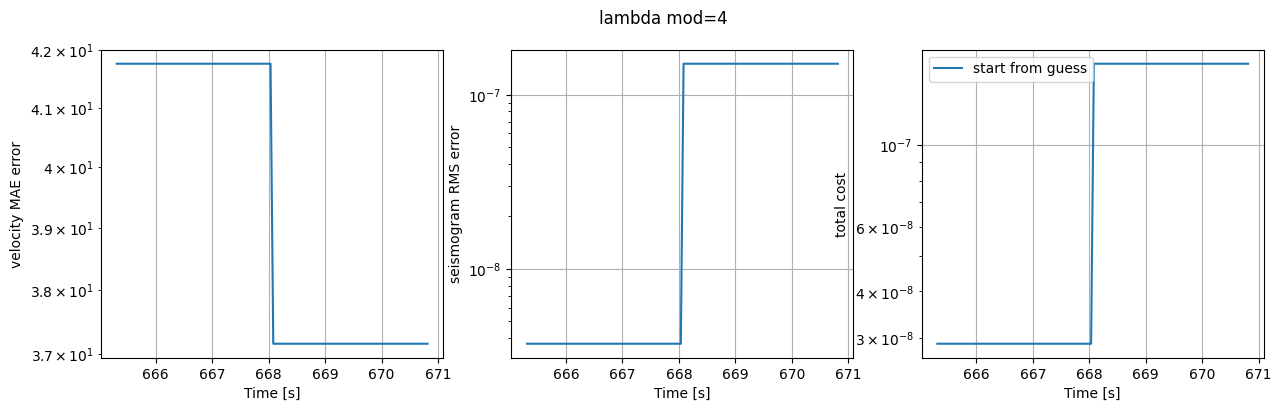

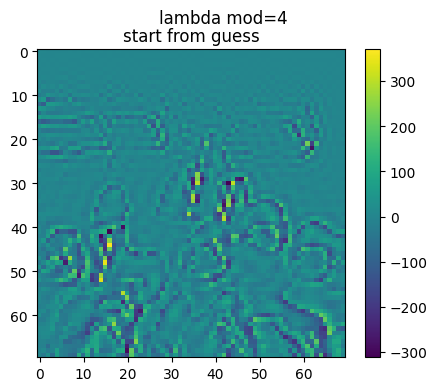

diag 1.4725289210368968e-05


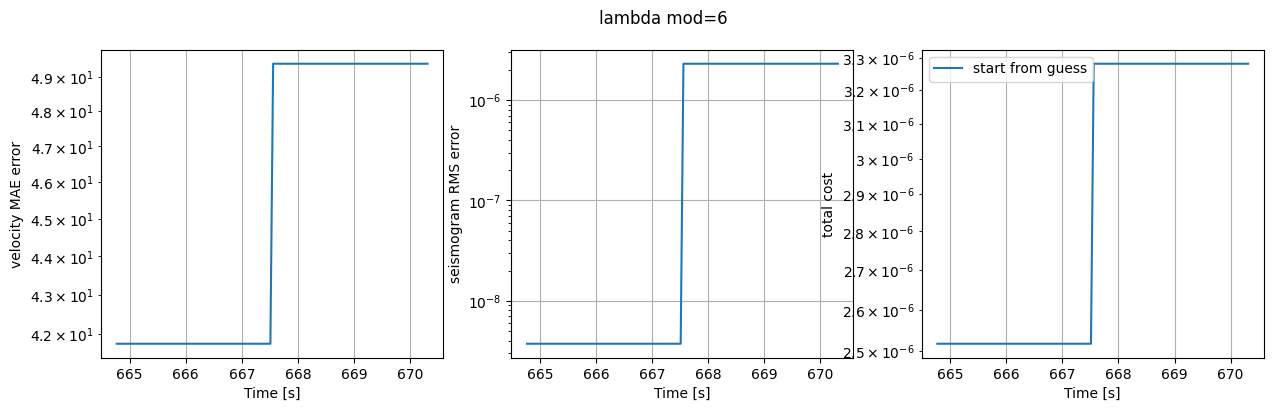

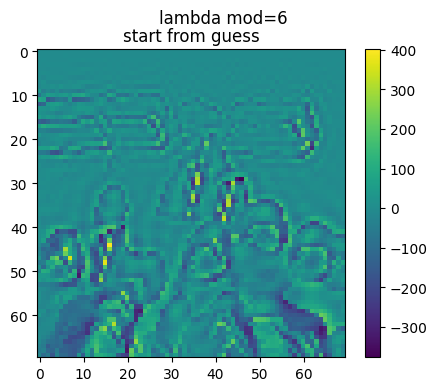

diag 1.4725289210368968e-05


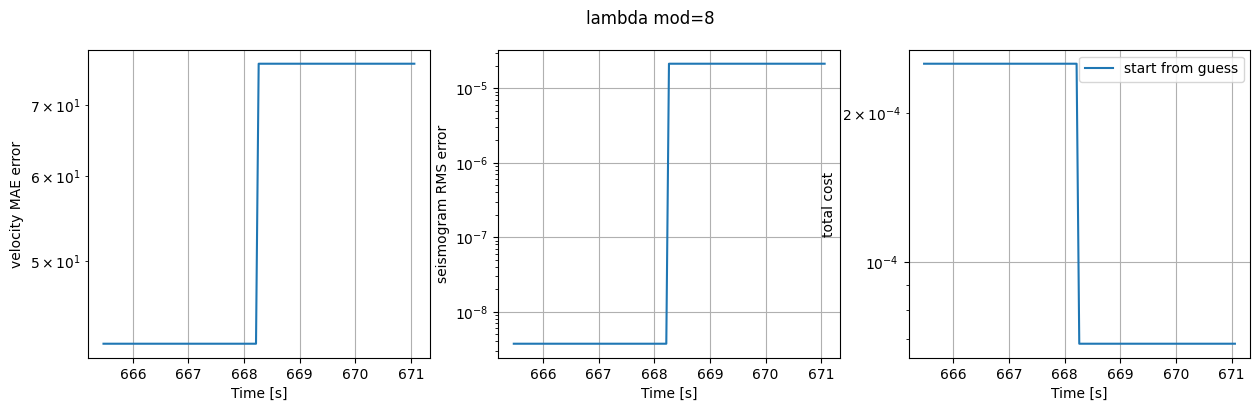

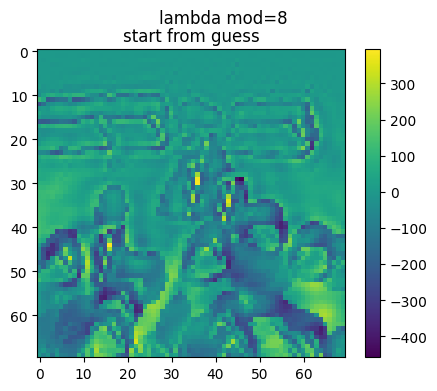

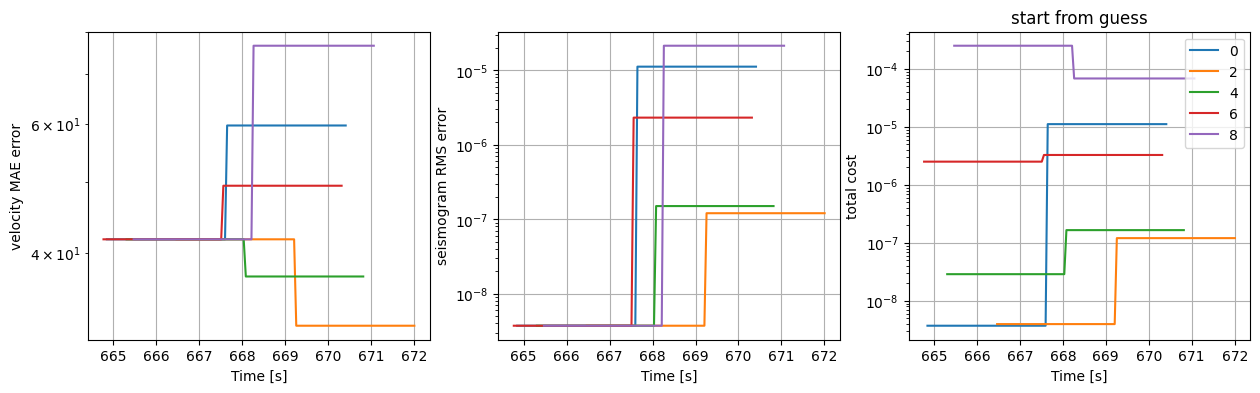

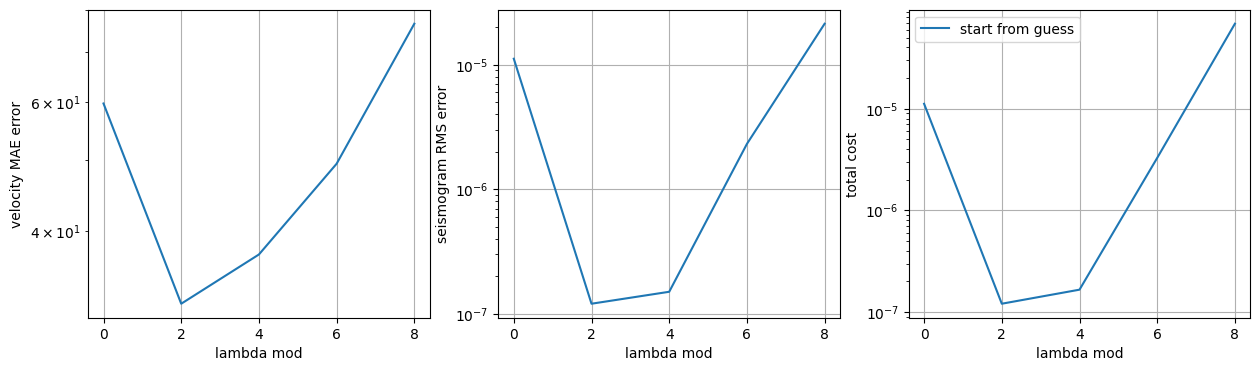

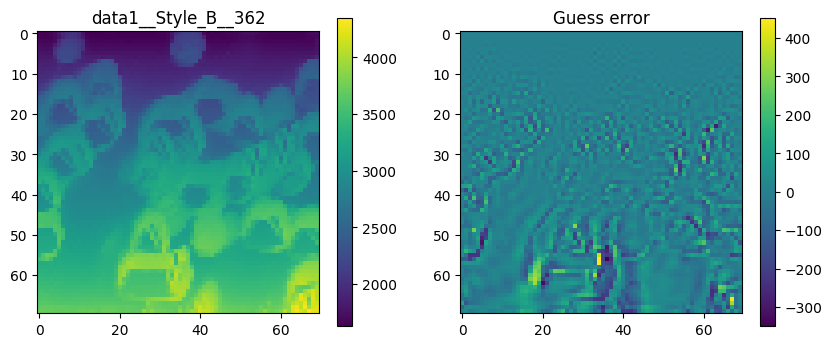

diag 1.5321841937989776e-05


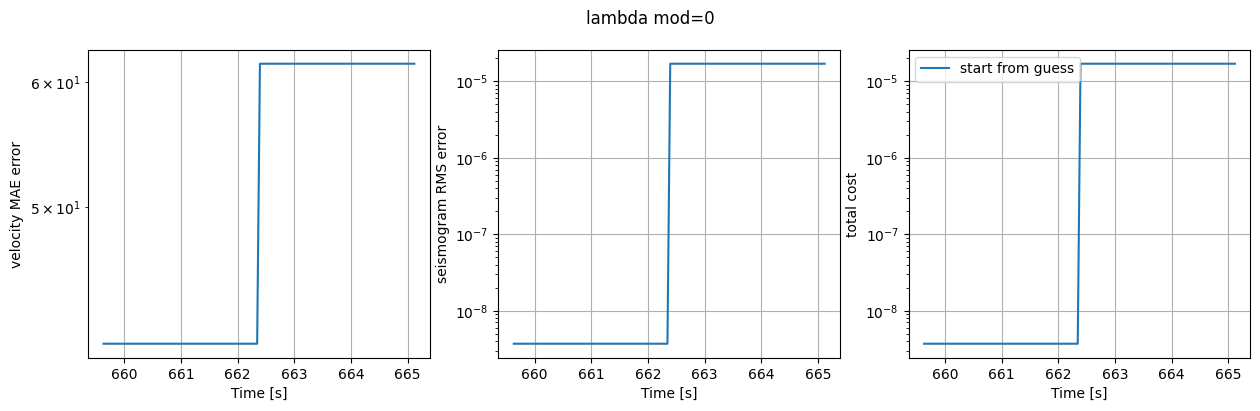

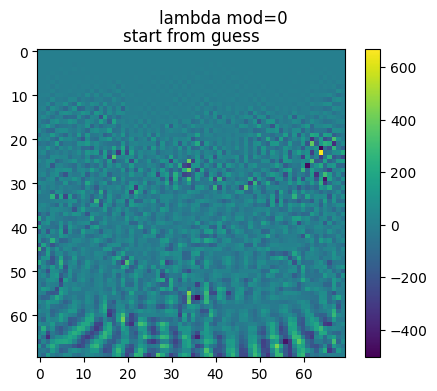

diag 1.5321841937989776e-05


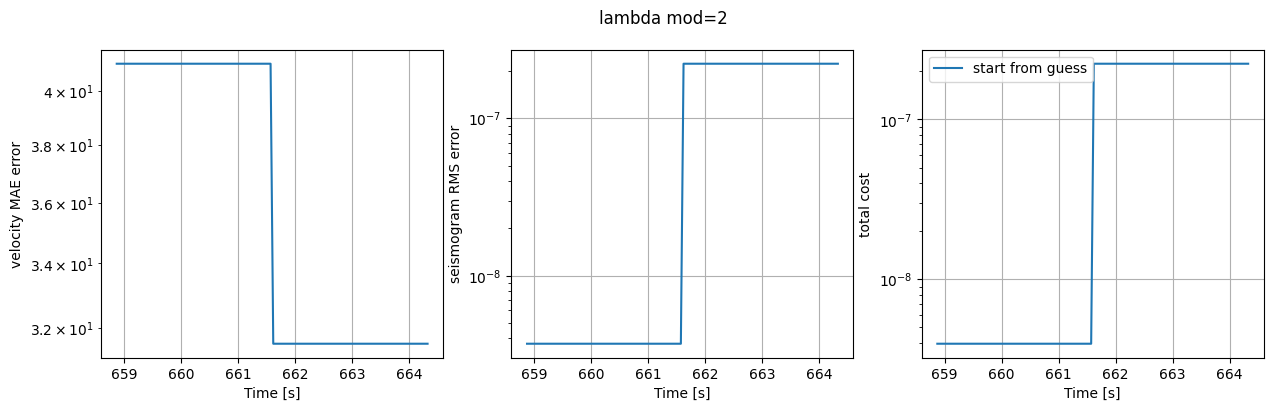

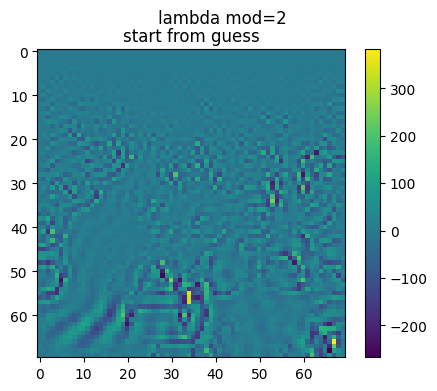

diag 1.5321841937989776e-05


In [ ]:
importlib.reload(seis_prior)
importlib.reload(seis_diagnostics)
importlib.reload(seis_invert)
importlib.reload(seis_forward)
importlib.reload(seis_model)
kgs.profiling=False
seis_invert.profiling=False
kgs.debugging_mode = 0
seis_forward2.profiling=False
seis_forward2.reset_profile()

# transform back on, history size to infinite, maxiter down
xx = copy.deepcopy(seis_model.default_model())
model = copy.deepcopy(xx.models[1].model_Style_B)
model.show_convergence = True
model.iter_list = [0]
#model.prior.noise = 0.6
#model.prior.transform = False
#model.prior.svd_cutoff = -1.
#model.prior.λ = 10**-12

start_model = copy.deepcopy(xx.models[1].model_Style_B)

do_which_list = [False,False,True]

def param_func(model,value):
    model.prior.λ *= 10**value
    return model
    
param_values = [0,2,4,6,8]
param_name = "lambda mod"


for d in data:
    results = seis_diagnostics.do_diagnostics_run(d, model, do_which_list, param_func, param_values, param_name, help_fac=0., start_model = start_model)